# Import packages

/Users/amirhsi/miniconda3/envs/polylab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


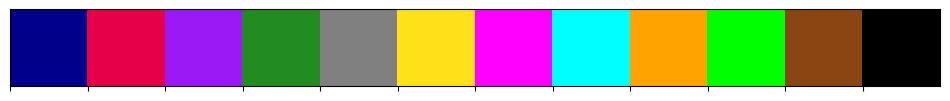

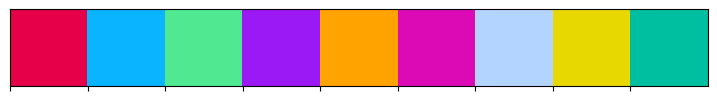

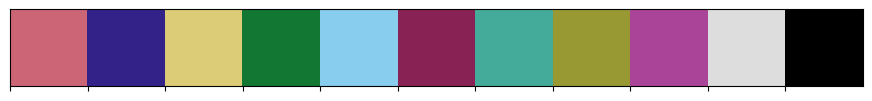

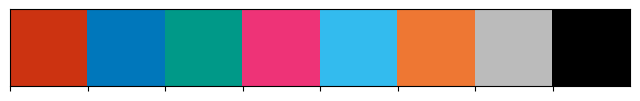

In [2]:
# Importing necessary packages:
from glob import glob
import re
import numpy as np
import pandas as pd
import itertools
from  matplotlib import colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_VIBRANT as PTV
from polyphys.visualize.plotter import SIZE_MEASURES_LABELS as SML

from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.manage import utilizer
from polyphys.manage.parser import TransFociCub, TransFociCyl

sns.palplot(AC)
sns.palplot(DF_colors)
sns.palplot(PTM)
sns.palplot(PTV)

import warnings
warnings.filterwarnings("ignore")

# Merge spaces with same $a_l$ but different $a_c$

## Direct contacts and clusters

In [2]:
project = 'TransFociCub'
allInOne_dbs = ['/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/', '../../Datasets/'+project+'-allInOne/']
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
measures = ['mean', 'sem', 'var']
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free Space', 'Free Space-LJ_pow12', 'TransFociCub-InitialCompressed'] # TransFocuCyl added later
foci_list = []
project_title_style = ''
project_titles = {}
for allInOne_db in allInOne_dbs:
    projects_comon_title = ''
    for prop in hist_properties:
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = allInOne_db + hist_df
        print(hist_df)
        hist_df = pd.read_parquet(hist_df)
        if project == 'TransFociCyl':
            hist_df['geometry'] = hist_df['dcyl'].apply(lambda x: rf"${x}$")
            hist_df['geometry_fullname'] = geometry_names_full[project] + hist_df['dcyl'].apply(lambda x: f"$D={x}$")
        else:
            hist_df['geometry'] = r'$\infty$'
            hist_df['geometry_fullname'] = geometry_names_full[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        hist_df.rename(columns={prop + '-norm': 'probability'}, inplace=True)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
            style = TS[project]
            cond = hist_df['space']==space
            hist_df.loc[cond,'space_title'] = style['title'](s_info)
            hist_df.loc[cond,'space_title_short'] = style['short'](s_info)
            hist_df.loc[cond,'universe'] = style['universe'](s_info)
            
            if s_info.dmon_large == 5.0:
                projects_comon_title = (
                    fr"$N_m={s_info.nmon_small},$ " +
                    fr"$N_M={s_info.nmon_large},$ " +
                    fr"$a_c={s_info.dcrowd}$"
                )
        project_titles[project] = projects_comon_title 
        foci_list.append(hist_df)     
foci = pd.concat(foci_list, axis=0)
foci.reset_index(inplace=True, drop=True)
print(foci.columns)
# For free space dcyl=0
#foci['dcyl'].fillna(value=0, inplace=True) # this is when studies TransFociCyl
# For all project
foci['dcyl'] = 0 # This is for when studying TrasFociCub alone
foci.drop(columns=['bin_center-norm', 'space', 'ensemble', 'phi_c_bulk'], inplace=True)
print('columns:' , foci.columns)
# cdfs

foci_grouped = foci.groupby(['dmon_large', 'phi_c_bulk_round', 'geometry', 'property'])

# Function to calculate the cumulative distribution function
def calculate_cdf(group):
    # Sort by the 'bin_center' to ensure proper CDF calculation
    group = group.sort_values(by='bin_center')
    # Calculate the cumulative sum of probabilities
    group['cdf'] = group['probability'].cumsum()
    return group

# Apply the function to each group and calculate CDF for each 'property'
foci_cdf = foci_grouped.apply(calculate_cdf)
foci_cdf.reset_index(drop=True, inplace=True)


# Weighed average of cluster size and direct contact:
gb_cols = ['dmon_large', 'phi_c_bulk_round', 'geometry', 'geometry_fullname','property', 'dcrowd', 'nmon_large', 'nmon_small', 'dcyl', 'ensemble_long']
foci_weighted = foci.groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability']).sum() / x['probability'].sum())
# give the result a meaningful name
foci_weighted = foci_weighted.rename("bin_center-average").reset_index()
foci_weighted.rename(
    columns={'bin_center-average': 'value'},
    inplace=True
    )


/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/allInOne-TransFociCub-bug-clustersHistFoci.parquet.brotli
/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/allInOne-TransFociCub-bug-bondsHistFoci.parquet.brotli
../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-bug-clustersHistFoci.parquet.brotli
../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-bug-bondsHistFoci.parquet.brotli
Index(['bin_center', 'bin_center-norm', 'probability', 'space',
       'ensemble_long', 'ensemble', 'nmon_small', 'nmon_large', 'dmon_large',
       'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'geometry',
       'geometry_fullname', 'property', 'space_title', 'space_title_short',
       'universe'],
      dtype='object')
columns: Index(['bin_center', 'probability', 'ensemble_long', 'nmon_small',
       'nmon_large', 'dmon_large', 'dcrowd', 'phi_c_bulk_round', 'geometry',
       'geometry_fullname', 'property', 'space_title', 'space_title_short',
       'universe', 'dcyl'],
      dtyp

## Equilibrium properties

In [3]:
phase = 'ensAvg'
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']
project = 'TransFociCub'
allInOne_dbs = ['/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/', '../../Datasets/'+project+'-allInOne/']
# TransFociCyl added later
geometry_names_full = {
    #'TransFociCub': 'Free Space',
    'TransFociCub': 'Free Space (Chain equilibrated)',
    'TransFociCub-LJ_pow12':  'Free Space (LJ repulsion only)',
    'TransFociCub-InitialCompressed': 'Free Space (Chain and crowders equilibrated)',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}
chainsize_trans_foci = []
project_title_style = ''
project_titles = {}
for allInOne_db in allInOne_dbs:
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps',
         phase
        ])
    equil_db = allInOne_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    # phi_c to drop
    if project == 'TransFociCyl':
        chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
    print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
    
    # rho_m in the sphere created by it gyr
    chainsize_equil['rho_m_self'] = \
        (3 * (chainsize_equil['nmon_large'] + chainsize_equil['nmon_small'])) / (4 * np.pi * chainsize_equil['gyrMon-mean'] ** 3)
    # phi_m in the sphere created by it gyr: dmon = 1
    chainsize_equil['phi_m_self'] = \
        (3 * (chainsize_equil['nmon_large'] * np.pi * chainsize_equil['dmon_large'] ** 3 / 6 + chainsize_equil['nmon_small']) * np.pi / 6) / (4 * np.pi * chainsize_equil['gyrMon-mean'] ** 3)
    chainsize_equil.reset_index(inplace=True, drop=True)
    # selecting 'norm' measures of properties
    attributes = PD[project]['equil_attributes'] + ['rho_m_self', 'phi_m_self']
    # globe size line
    if project == 'TransFociCyl':
        dmon_large_cond = (chainsize_equil['dmon_large'] == 5)
        phi_c_cond = (chainsize_equil['phi_c_bulk_round'] == 0)
        gyr_phic0_dmon_large = chainsize_equil.loc[dmon_large_cond & phi_c_cond, 'gyrMon-mean'].values[0]
        nmon_small = chainsize_equil['nmon_small'].values[0]
        nmon_large = chainsize_equil['nmon_large'].values[0]
        globe_size = (nmon_small + nmon_large) ** (1/3)
        r_globe_ratio = globe_size/gyr_phic0_dmon_large
    #norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
    # option 1: norms of asphericityMon-norm and shapeMona
    #selected_cols = attributes + norm_props
    #value_vars = norm_props
    # option 2: means of asphericityMon-norm and shapeMona
    gyr_fsd_only_norm_props = [
        'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
    ]
    selected_cols = attributes + gyr_fsd_only_norm_props
    print(selected_cols)
    value_vars = gyr_fsd_only_norm_props
    # melting properties column
    chainsize_melted = chainsize_equil[selected_cols].melt(
        id_vars=attributes,
        value_vars=value_vars,
        var_name='property'
    )
    # dictionary of normalizer properties' features
    spaces = chainsize_melted['space'].unique()
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
    project_titles[project] = project_title_style
    if project == 'TransFociCyl':
        chainsize_melted['geometry'] = chainsize_melted['dcyl'].apply(lambda x: rf"${x}$")
        chainsize_melted['geometry_fullname'] = geometry_names_full[project] + chainsize_melted['dcyl'].apply(lambda x: f" ($D={x}$)")
    else:
        chainsize_melted['geometry'] = r'$\infty$'
        chainsize_melted['geometry_fullname'] = geometry_names_full[project]
    chainsize_trans_foci.append(chainsize_melted)

chainsize_trans_foci =  pd.concat(chainsize_trans_foci, axis=0)
chainsize_trans_foci.reset_index(inplace=True, drop=True)
chainsize_trans_foci.drop(columns=['space', 'ensemble', 'phi_c_bulk'], inplace=True)

# For free space dcyl=0
#chainsize_trans_foci['dcyl'].fillna(value=0, inplace=True) # this is when studies TransFociCyl
# For all project
chainsize_trans_foci['dcyl'] = 0 # This is for when studying TrasFociCub alone


#chainsize_trans_foci.to_csv("../../Datasets/TransFoci-allInOne_InitialCompressed-phi_m_self-rho_m_self-ensAvg.csv", index=False)
# cubic geometry does not have 'dcyl' values, so fill it with 0
chainsize_trans_foci.fillna(0, inplace=True)
# merge cluster info with chain size info:
equi_props = pd.concat([chainsize_trans_foci, foci_weighted])

unique phi_c_bulk: [0.0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
['ensemble_long', 'ensemble', 'space', 'dmon_large', 'nmon_large', 'nmon_small', 'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'rho_m_self', 'phi_m_self', 'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm']
unique phi_c_bulk: [0.0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
['ensemble_long', 'ensemble', 'space', 'dmon_large', 'nmon_large', 'nmon_small', 'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'rho_m_self', 'phi_m_self', 'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm']


NameError: name 'foci_weighted' is not defined

In [4]:
# save different ac all in one
#dmon_large = 6.0
#equi_props.to_csv(f"../../Datasets/TransFoci-allInOne-al{dmon_large}-contact-ensAvg.csv", index=False)

## Local spatial distributions:

In [4]:
project = 'TransFociCub'
allInOne_dbs = ['/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/', '../../Datasets/'+project+'-allInOne/']
phase = 'ensAvg'
# distributions
directions = ['r']
props = ['Phi' , 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Foci', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']#, 'norm-bulk']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Big mon.', 'Small mon.', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
group = 'all'
geometry = 'cubic'
var_cols = []
dist = []
local_dist_all = []

for allInOne_db in allInOne_dbs:
    # equilibirum properties
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps', phase]
    )
    equil_db = allInOne_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    # stamps
    equil_db = '-'.join(
        ['allInOne', project, 'stamps', phase]
    )
    equil_db = allInOne_db + equil_db + '.csv'
    stamps = pd.read_csv(equil_db) 
    stamps['runtime'] = stamps['bdump'] * (stamps ['n_frames'] - 1)
    stamps['n_frames-adump'] = (stamps['runtime'] / stamps['adump']) + 1
    for normalizing_method in normalizing_methods:
        dist_per_norm = []
        melting_dict = [
            species + '-' + normalizing_method for species in species_list
        ]
        melting_dict.append('Sum-sumrule_local')
        for direction, prop in dir_prop_pairs:
            prop_fullname = direction + prop
            equil_db = '-'.join(['allInOne', project, group, prop_fullname])
            equil_db += '-NormalizedScaled.parquet.brotli'
            equil_db = allInOne_db + equil_db
            local_dist = pd.read_parquet(equil_db)
            # bulk profiles of crowders in the crowder-only region
            ensembles = local_dist['ensemble_long'].unique()
            local_dist['bulk_profile-crowder_only'] = 0.
            local_dist['bulk_profile'] = 0.
            local_dist['rho_c_bulk'] = 0.
            cond_bin_center = (local_dist['bin_center-norm']<=0.86) & (local_dist
                ['bin_center-norm']>=0.6)
            for ens in ensembles:
                n_frames = stamps.loc[stamps['ensemble_long']==ens,'n_frames-adump'].values[0]
                cond_ens = (local_dist['ensemble_long']==ens)
                conds = cond_bin_center & cond_ens
                phi_c_crowder_only = local_dist.loc[conds,prop_fullname+ 'Crd-mean'].mean()
                local_dist.loc[local_dist['ensemble_long']==ens,'rho_c_bulk'] = stamps.loc[stamps['ensemble_long']==ens,'rho_c_bulk'].values[0]
                local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile-crowder_only'] = phi_c_crowder_only / n_frames
                if prop == 'Phi':
                    bulk_profile = local_dist.loc[cond_ens,'phi_c_bulk_round'].values[0]
                else:
                    bulk_profile = local_dist.loc[cond_ens,'rho_c_bulk'].values[0]
                local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile'] = bulk_profile

            # Re-normalizing bin_center along r direction based on largest lcube
            # in ensemble with phi_c=0 in each space
            # Assuming TransFociCub returns an object with an lcube attribute
            local_dist['lcube'] = local_dist['ensemble_long'].apply(
                lambda x: TransFociCub(
                    x, 'ensemble_long', geometry, group, 'linear', ispath=False).lcube)

            grouped = local_dist.groupby(['phi_c_bulk_round', 'dmon_large', 'dcrowd'])
            lcyl_for_combinations = grouped['lcube'].first()

            # Extract lcube for phi_c_bulk_round == 0
            lcube_phi_c_0 = local_dist[local_dist['phi_c_bulk_round'] == 0].groupby(['dmon_large', 'dcrowd'])['lcube'].first()
            def calculate_correction_ratio(row):
                phi_c_0 = lcube_phi_c_0.get((row['dmon_large'], row['dcrowd']))
                return row['lcube'] / phi_c_0 if phi_c_0 else None
            local_dist['correction_ratio'] = local_dist.apply(calculate_correction_ratio, axis=1) 
            local_dist['bin_center-norm-corrected'] = local_dist[
                'bin_center-norm'] * local_dist['correction_ratio']
            local_dist['bin_center-norm-dmon_large'] = local_dist[
                'bin_center'] / local_dist['dmon_large']
            # Normalizing bin_center with gyr:
            gyr_grouped = local_dist.groupby(['dmon_large','dcrowd'])
            gyr_phi_c_0 = chainsize_equil[chainsize_equil['phi_c_bulk_round'] ==
                                        0].groupby(
                                            ['dmon_large', 'dcrowd'])['gyrMon-mean'].first()
            def calculate_correction_ratio(row):
                phi_c_0 = gyr_phi_c_0.get((row['dmon_large'], row['dcrowd']))
                return row['bin_center'] / phi_c_0 if phi_c_0 else None
            local_dist['bin_center-gyr_mean'] = local_dist.apply(calculate_correction_ratio, axis=1) 
             
            #local_dist['bin_center-gyr_mean'] = local_dist.apply(
            #    lambda row: row['bin_center'] / gyr_phi_c_0[['dmon_large','dcrowd']],
            #    axis=1)
            ensembles = local_dist['ensemble_long'].unique()

            #for ens in ensembles:
            #    ens_cond_eq = chainsize_equil['ensemble_long']== ens
            #    ens_cond = local_dist['ensemble_long']== ens
            #    gyr_mean = \
            ##        chainsize_equil.loc[ens_cond_eq, 'gyrMon-mean'].values[0]
            #    local_dist.loc[ens_cond, 'bin_center-gyr_mean'] = local_dist.loc[ens_cond, 'bin_center'] / gyr_mean
            # Dropping redundant columns
            cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
            local_dist.drop(columns=cols_to_drop, inplace=True)
            # Sumrule at local level
            local_dist[prop_fullname + 'Sum-sumrule_local'] = 0
            for species in species_list:
                local_dist[prop_fullname+'Sum-sumrule_local'] += \
                    local_dist[prop_fullname+species+'-scale']
            local_dist[prop_fullname+'Sum-sumrule_local'] = \
                (local_dist[prop_fullname+'Sum-sumrule_local'] /
                local_dist[prop_fullname+'Crd-normalizer'])
            # Melting based local distributions on species:
            attributes = PD[project]['equil_attributes'].copy()
            attributes += [
                'bin_center', 'bin_center-norm', 'bin_center-dcrowd',
                'bin_center-gyr_mean', 'bin_center-norm-dmon_large',
                'bin_center-norm-corrected', 'bulk_profile-crowder_only',
                'bulk_profile'
            ]
            var_name = 'species'
            var_cols = [prop_fullname + col for col in melting_dict]
            sel_cols = attributes + var_cols
            local_dist_melted = local_dist[sel_cols].melt(
                id_vars=attributes,
                value_vars=var_cols,
                value_name=normalizing_method + '_' + var_name + '_value',
                var_name=var_name)
            # Renaming values
            local_dist_melted.loc[:, var_name] = \
                local_dist_melted.loc[:, var_name].apply(
                    lambda x: x.split('-')[0].split(prop_fullname)[-1]
                )
            local_dist_melted.loc[:, var_name] = \
                local_dist_melted.loc[:, var_name].apply(
                    lambda x: species_names_dict[x]
            )
            # Dropping distributions with phi_c=0
            local_dist_melted = \
                local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
            # Fixing near-end problem in crowder distributions
            cond = local_dist_melted['bin_center-norm'] <= 0.98
            local_dist_melted = local_dist_melted.loc[cond, :]
            # local_dist_melted
            local_dist_melted['direction'] = direction
            local_dist_melted['property'] = prop
            
            dist_per_norm.append(local_dist_melted)
        dist_per_norm = pd.concat(dist_per_norm, axis=0)
        dist_per_norm.reset_index(inplace=True, drop=True)
        dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'],
                        inplace=True)  
        dist.append(dist_per_norm)

dist = pd.concat(dist) # nan is due to the norming method: two different columns
dist.reset_index(inplace=True, drop=True)
spaces = dist[['nmon_small','nmon_large','dmon_large']].drop_duplicates().sort_values(by=['nmon_small','nmon_large', 'dmon_large']).values
project_titles = {}
for (nmon_small, nmon_large, dmon_large,) in spaces:
    project_title_style = {
        'TransFociCub': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, a_M={dmon_large}$",
        'TransFociCub-InitialCompressed': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, a_M={dmon_large}$"
        #'TransFociCub': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, {{a_l}}/{{a_m}}={dmon_large}$",
        #'TransFociCub-InitialCompressed': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, {{a_l}}/{{a_m}}={dmon_large}$"
        }
    project_titles[project] = project_title_style[project]

del directions, props, dir_prop_pairs, species_list, normalizing_methods
del normalizing_method, melting_dict, species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols


## Viz

### Equilibrium properties: Quantities as rows, $a_c$ as cols, $a_l$ as hue: 
#### Not good chain propertiees, including size, should be the same across systems, to make comparsion more (apple should be compared with apple)

In [22]:
plot_params = {
    'talk': {
    'height': 3.5,
    'aspect': 1,#6/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.05, 0.05),
    },
    'paper': {
    'height': 2.25,
    'aspect': 1,#6/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2,
    'bbox_to_anchor':(0.5, -0.04),
    }
}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'serif'
#math_font = 'dejavusans'
#rc_params= {
#    'font.family': font_family,
#    'font.serif': 'Times New Roman',
#    'axes.formatter.use_mathtext': True,
#}
rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': False,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'ncol': 2,
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.5, 'y': 1, 'ha': 'center'}
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci',]
property_cond = (equi_props['property'].isin(property_order))
data = equi_props.loc[property_cond]
data.reset_index(inplace=True, drop=True)
p_attrs = {
    'nmon_large': 5,
    'nmon_small': 400
}
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large'
color_palette = 'flare' # PTM[:len(data[hue_attr])]
col_attr = 'dcrowd'
col_order = sorted(data[col_attr].unique()) 
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
sns.reset_defaults()
plot_context = 'paper'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=plot_params[plot_context]['font_scale'],
    rc=rc_params
)
#for plot_context in ['paper']:#, 'talk']:
#    with sns.axes_style('ticks'):
#        with sns.plotting_context(
#            plot_context,
#            font_scale=plot_params[plot_context]['font_scale'],
#            rc=rc_params
#            ):
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    row=row_attr,
    col=col_attr,
    row_order=row_order,
    col_order=col_order,
    hue=hue_attr,
    style=hue_attr,
    dashes=False,
    markers=True,
    #markers=['s','o'],
    #marker='s',
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    #markersize=5,
    alpha=0.8,
    #lw=2
    )
grid.set_titles("")
#grid.set_titles("$a_c={col_name}$", **fig_title_kws)
grid.set_xlabels(AL[x_prop])
for irow in range(len(row_order)):
    for icol in range(len(col_order)):
        ax = grid.axes[irow,icol]
        ax.set_xlabel(AL[x_prop])
        if irow == 0 :
            ax.set_title(fr"$a_c={col_order[icol]}$", **fig_title_kws)
            ax.set_ylabel(AL['gyrMon-norm'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.05,1.05)
        elif irow == 1:
            ax.set_ylabel(AL['bondsHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['bondsHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.5,4.5)
        else:
            ax.set_ylabel(AL['clustersHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['clustersHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(0.5,5.5)

handles, labels = grid.axes[0,0].get_legend_handles_labels()
color_labels = [rf'$a_M={float(label)}$' for label in labels]
sns.move_legend(
    grid,
    labels=color_labels,
    title=None,
    loc='lower center',
    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    ncol=6
)
grid.tight_layout(w_pad=0.2, h_pad=0.2)
output = "-".join(
    ["Equilibrium_properties", "dcrowd_as_hue", "dmon_large_col", plot_context]
    )
grid.figure.align_ylabels()
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

### Equilibrium properties: Quantities as rows, $a_l$ as cols, $a_c$ as hue

In [15]:
plot_params = {
    'talk': {
    'height': 3.5,
    'aspect': 1,#6/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.05, 0.05),
    },
    'paper': {
    'height': 2,
    'aspect': 1,#6/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.48, -0.04),
    }
}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'serif'

rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both',
    'xtick.direction': 'inout',
    'ytick.direction': 'inout'
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'ncol': 2,
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.5, 'y': 1, 'ha': 'center'}
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci',]
property_cond = (equi_props['property'].isin(property_order))
data = equi_props.loc[property_cond]
data.reset_index(inplace=True, drop=True)
p_attrs = {
    'nmon_large': 5,
    'nmon_small': 400
}
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dcrowd' # 
color_palette = 'flare' #PTM[:len(data[hue_attr])]
col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique()) 
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
sns.reset_defaults()
plot_context = 'paper'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=plot_params[plot_context]['font_scale'],
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    row=row_attr,
    col=col_attr,
    row_order=row_order,
    col_order=col_order,
    hue=hue_attr,
    style=hue_attr,
    dashes=False,
    markers=True,
    #markers=['s','o'],
    #marker='s',
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    #markersize=5,
    alpha=0.8,
    #lw=2
    )
grid.set_titles("")
#grid.set_titles("$a_M={col_name}$", **fig_title_kws)
grid.set_xlabels(AL[x_prop])
for irow in range(len(row_order)):
    #for icol in range(len(col_order)):
    for icol, letter in enumerate("ABCDE"):
        ax = grid.axes[irow,icol]
        ax.set_xlabel(AL[x_prop])
        if irow == 0 :
            ax.set_title(fr"{letter}) $a_M={col_order[icol]}$", **fig_title_kws)
            ax.set_ylabel(AL['gyrMon-norm'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_yticks(np.arange(0,1.2,0.2))
            ax.set_ylim(-0.05,1.05)
        elif irow == 1:
            ax.set_ylabel(AL['bondsHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['bondsHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.5,4.5)
        else:
            ax.set_ylabel(AL['clustersHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['clustersHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(0.5,5.5)

handles, labels = grid.axes[0,0].get_legend_handles_labels()
color_labels = [rf'$a_c={float(label)}$' for label in labels]
sns.move_legend(
    grid,
    labels=color_labels,
    title=None,
    loc='lower center',
    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    ncol=6
)
grid.tight_layout(w_pad=0.2, h_pad=0.2)
output = "-".join(
    ["Equilibrium_properties", "dmon_large_col", "dcrowd_as_hue", plot_context]
    )
grid.figure.align_ylabels()
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

### Why do larger crowders seem better in chain compaction:

In [16]:
nu = 0.588
c_flory = 1.12
c_rog = 1.18
n_mon = 100
r_flory = c_flory * n_mon**nu
print(f"Flory's radius: {round(r_flory, 3)}")
rog = c_rog * n_mon**nu 
print(f"Radius of gyration: {round(rog, 3)}")

Flory's radius: 16.796
Radius of gyration: 17.696


### Equilibrium properties: Quantities as rows, single $a_l$, $a_c$ as hue: Not goofd y lkims


In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 2.5,
    'aspect': 2*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci',]
property_cond = (equi_props['property'].isin(property_order))
dmon_large_cond_val = 1.0
dmon_large_cond = (equi_props['dmon_large']==dmon_large_cond_val)
data = equi_props.loc[property_cond & dmon_large_cond]
data.reset_index(inplace=True, drop=True)
p_attrs = {
    'nmon_large': 5,
    'nmon_small': 400
}
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }

x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dcrowd' # 'dmon_large'
color_palette = PTM[:len(data[hue_attr])]
row_attr = 'property'
row_order = property_order 
for plot_context in ['paper']:#, 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                marker='s',
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                lw=2
                )
            
            grid.set_titles("")
            grid.axes[0].set_title(f"$D=\infty, a_l={dmon_large_cond_val}$")
            
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            handles, labels = grid.axes[0].get_legend_handles_labels()
            color_handles = handles[:len(data[hue_attr].unique())+1]
            color_labels = labels[:len(data[hue_attr].unique())+1]
            #color_labels[0] = AL[hue_attr]
            grid.axes[0].legend(
                color_handles,
                color_labels,
                title=AL[hue_attr],
                loc='lower left',
                ncol=2,
                **legend_kws
            )
            grid._legend.remove()
            if plot_context == 'talk':
                grid.figure.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Equilibrium_properties",
                 "dmon_large_as_line_style", "dcrowd_as_hue", f"dmon_large{dmon_large_cond_val}", plot_context])
            #plt.show()
            grid.figure.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### Spatial distribution: normalized by gyr

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    dir_cond = (dist['direction'].isin([direction]))
    bin_center_max = 0.93
    bin_center_cond = (dist['bin_center-norm'] <= bin_center_max) 
    property_ = 'Phi'
    prop_cond = (dist['property'].isin([property_]))
    phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
    species_cond = (dist['species'].isin(['Crowders', 'Small mon.', 'Big mon.']))
    dmon_large_chosen = 1.0
    dmon_large_cond = (dist['dmon_large'].isin([dmon_large_chosen]))
    dcrowd_cond = (dist['dcrowd'].isin([dmon_large_chosen]))
    x_prop = 'bin_center-gyr_mean'
    #r_gyr_cut = 
    #bin_center_cond = (dist[x_prop]<=r_gyr_cut)
    cond = dir_cond & prop_cond & bin_center_cond & species_cond & phi_cond & dmon_large_cond #
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # plotting style
    # Rescaling bin centers by crowder size
 
    ext = 'pdf'
    save_to = './'

    x_prop_name = x_prop + '-' + direction + '-cub'
    
    y_prop = 'norm_species_value'

    col_attr = 'dcrowd'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'species'
    row_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

    style_attr = 'species'
    style_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 2.5
    aspect = 1#0.9*16/8
    plot_context = 'paper'
    rc_params = {
        'axes.facecolor': 'white',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': False,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
        }
    save_to = '../../test_plots/'
    font_scale = 1
    fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
    facet_kws = {'sharey': True, 'sharex': True, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        #'bbox_to_anchor': (0.78, 0.92),
        'bbox_to_anchor': (0.85, 0.93), # Paper
        #'bbox_to_anchor': (0.6, 0.9), # talk
        'frameon': False,
        'facecolor': 'white',
        'borderpad': 0.1,
        'ncols': 1,
        'markerscale': 1.,
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 5
    else:
        markevery = 15
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        #style=style_attr,
        #style_order=style_order,
        #markers=True,
        #dashes=False,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        #markersize=20,
        #markevery=markevery,
        alpha=0.8,
        lw=1.5,
        )
    grid.set_titles(AL['dmon_large'] + f"$={dmon_large_chosen}$, " + AL[col_attr] + r"$={col_name}$")
    grid.set_xlabels(AL[x_prop_name])
    legend_labels = list(hue_order)
    for idx, new_label in enumerate(legend_labels):
        grid._legend.legend_handles[idx].set_linewidth(5)

    for i, species in enumerate(row_order):
        for j in range(len(col_order)):
            grid.axes[i,j].set_ylabel(
                AL[direction+property_+'-norm-'+species_shortnames[species]]
            )
    handlers, labels = grid.axes[0,0].get_legend_handles_labels() 
    grid.axes[0,-1].legend(
        handlers,
        labels,
        title=AL[hue_attr],
        loc='center right',
        handletextpad=0.5,
        frameon=False
    )
    #sns.move_legend(grid, title=AL[hue_attr], loc='upper left',
    #**move_legend_kws)
    grid.legend.remove()
    output = "-".join(
        ["equilPlot", project, direction + property_, f'NormalizedScaled-speciesPerRow-dcrowdPerCol-dmon_large{dmon_large_chosen}-gyr_mean', plot_context]
    )
    grid.tight_layout(w_pad=0, h_pad=0.5)
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Sum Rule alone: all $a_l$ and $a_c$

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Phi', 'Rho']:
        species_cond = (dist['species'].isin(['Sum']))
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1 ,0.2, 0.225, 0.250, 0.275, 0.3, 0.4]))
        bin_center_max = 0.93
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        #dcrowd_chosen = 1.0
        #dcrowd_cond = (dist['dcrowd'].isin([dcrowd_chosen]))
        cond = dir_cond & prop_cond & bin_center_cond & species_cond & phi_cond
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-gyr_mean'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        row_attr = 'dcrowd'

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'  
        height = 4.25
        aspect = 1 #.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': False,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 1
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.9, 0.95),# (0.63, 0.45),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'ncol': 1,
            'markerscale': 2,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            row=row_attr,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.9,
            lw=1.5,
            )
        grid.set_titles(AL[col_attr] + r"$={col_name}$, " + AL[row_attr] + r"$={row_name}$")
        #grid.set_ylabels(AL[direction+property_+'-norm'])
        grid.map(plt.axhline, y=1.0, xmin=0.0,xmax=2.3,
                 color='darkgreen', lw=1.5,
                 label=AL[direction+property_+'-norm-Sum_constant'])

        #for idx, new_label in enumerate(handles):
        #    grid._legend.legend_handles[idx].set_linewidth(2)
        grid._legend.set_title(AL[hue_attr])
        sum_rule_handler = tuner.ls_handler([AL[direction+property_+'-norm-Sum_constant-cub']],
            ['-'],color='darkgreen',lw=2)
        for ax in grid.axes.flatten():
            ax.set_ylabel(AL[direction+property_+'-norm'])
            ax.set_xlabel(AL[x_prop_name])
            ax.set_ylim(0.45,2.75)
            ax.set_xlim(0,2.3)
            ax.legend(handles=sum_rule_handler,labels=[AL[direction + property_ + '-norm-Sum_constant-cub']], loc='lower right', frameon=False) 
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-dcrowdPerCol-SumRuleAlone']
        )
        grid.tight_layout(w_pad=0.5, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

# Comparing LJ potentials

In [ ]:
# Constants
sigma = 1.0
epsilon = 1.0
r_cut_LJ = 2.5 * sigma
r_cut_WCA = 2**(1/6) * sigma

# Define the ranges of r
r = np.linspace(0.9, r_cut_LJ, 500) # Avoid division by zero

# Lennard-Jones potential
U_LJ = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)
U_LJ[r > r_cut_LJ] = 0

# WCA potential
U_WCA = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6) + epsilon
U_WCA[r > r_cut_WCA] = 0

# Repulsive part of the LJ potential
U_repulsive = 4 * epsilon * (sigma/r)**12
U_repulsive[r > sigma] = 0

# Repulsive part of the LJ potential shifted
U_repulsive_shift = 4 * epsilon * (sigma/r)**12 - 4*epsilon
U_repulsive_shift[r > sigma] = 0

# Repulsive part of the LJ potential
U_repulsive_r_cut_WCA = 4 * epsilon * (r_cut_WCA/r)**12
U_repulsive_r_cut_WCA[r > r_cut_WCA] = 0

# Repulsive part of the LJ potential shifted
U_repulsive_r_cut_WCA_shift = 4 * epsilon * (r_cut_WCA/r)**12 - 4*epsilon
U_repulsive_r_cut_WCA_shift[r > r_cut_WCA] = 0

# Asakura-Oosawa depletion potenital
def asakura_oosawa_potential(r, a_m, a_c, phi_c, kT):
    v_c = np.pi*a_c**3/6
    press_spt = ((phi_c+phi_c**2+phi_c**3)/(1-phi_c)**3)*kT/v_c
    if r < a_m:
        return np.infty
    if r <= (a_m + a_c) and r >= a_m:
        return -1 * (np.pi/12) * press_spt * (a_c + a_c - r)**2 * (2*(a_m+a_c) - r - 3*(a_m-a_c)**2/r)
    else:
        return 0

ao_vect = np.vectorize(asakura_oosawa_potential, excluded=['a_m', 'a_c', 'phi_c', 'kT'])
U_ao = ao_vect(r,sigma, sigma, 0.2, epsilon)
U_ao_wca = ao_vect(r,r_cut_WCA, r_cut_WCA, 0.2, epsilon)

# Plotting
save_to = '../../test_plots/'
ext = 'pdf'
color_palette = sns.color_palette(PTM)
plot_context = 'paper'
height = 4
aspect_ratio = 16/9
rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #"text.latex.preamble": r"\usepackage{amsmath}",
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    'lines.linewidth': 1.75
    }

font_scale = 1.25
fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': False, 'legend_out': False}
move_legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'markerscale': 1.5,
    'framealpha': 1
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
plt.figure(figsize=(aspect_ratio*height, height))
#plt.plot(r, U_LJ, label=r'$U_{LJ}(r)=4\epsilon [(\sigma /r)^{12}-(\sigma /r)^{6}]$, $r \leq 2.5 \sigma$')
plt.plot(r, U_WCA, label=r'$U_{WCA}(r)=4\epsilon [(\sigma /r)^{12}-(\sigma /r)^{6}]+ \epsilon$, $r \leq 2^{1/6}\sigma$')
#plt.plot(r, U_repulsive, label=r'$U_{LJ,rep}(r)=4\epsilon (\sigma /r)^{12}$, $r \leq \sigma$',ls=':')
plt.plot(r, U_repulsive_shift, label=r'$U_{LJ,rep,shift}(r)=4\epsilon (\sigma /r)^{12}-4\epsilon$, $r \leq \sigma$', ls='--')
#plt.plot(r, U_ao, label=r'$U_{AO}(r)$ with $a_m=a_c=\sigma,\epsilon=k_BT, \phi_c=0.2$', ls=':')
#plt.plot(r, U_repulsive_r_cut_WCA, label=r'$U_{LJ,rep}(r)=4\epsilon (2^{1/6}\sigma /r)^{12}$, $r \leq 2^{1/6}\sigma$')
#plt.plot(r, U_repulsive_r_cut_WCA_shift, label=r'$U_{LJ,rep,shift}(r)=4\epsilon (2^{1/6}\sigma /r)^{12}-4\epsilon$, $r \leq 2^{1/6}\sigma$', ls='--')
#plt.plot(r, U_ao_wca, label=r'$U_{AO}(r)$ with $a_m=a_c=2^{1/6}\sigma,\epsilon=k_BT, \phi_c=0.2$')
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'Potential Energy ($\epsilon$)')
plt.ylim(-1.15,6.15)
plt.legend(**move_legend_kws)
plt.title(r'Comparison of LJ, WCA, and Repulsive LJ Potentials ($\sigma=1$ and $\epsilon=1$)')
output = 'Comparison_of_LJ_WCA_Repulsive_LJ_Potentials'
plt.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.show()

# PDF of distance between foci

## Importing datasets

In [ ]:
# loading databases
projects = ['TransFociCub']#, 'TransFociCyl']
pair_dist_properties = ['pairDistHistFoci', 'pairDistRdfFoci']
dcyl = 20
geometry_names_simple = {
    'TransFociCub': 'Free space',
    'TransFociCyl': fr'Cylindrical confinement',
}
geometry_orders_simple = ['Free space', 
                   fr'Cylindrical confinement']
# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': r'$D=\infty$',
    'TransFociCyl': '', # defined later
}
geometry_names_full_value = {
    'TransFociCub': r'$\infty$',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free space'] # TransFocuCyl added later

project_foci_gen_dist = []
project_foci_pair_dist = []
project_titles = {}
project_title_style = ''
n_subchain = 0
for project in projects:
    allInOne_db = '../../Datasets/'+project+'_InitialCompressed-allInOne/' # relative
    #allInOne_db = '/Users/amirhsi_mini/research_data/do_not_delete/'+project+'-allInOne/'
    space_dbs = glob(allInOne_db + PD[project]['space_pat'])

    prop = pair_dist_properties[1]
    # LOad data
    dist_map = '-'.join(
        ['allInOne', project, PD[project]['group'],
         'pairDistStats.parquet.brotli']
        )
    dist_map = allInOne_db + dist_map
    dist_map = pd.read_parquet(dist_map)
    # rounding phi_c values:
    divisor = 0.025
    round_to = 3
    dist_map['phi_c_bulk_round'] = dist_map['phi_c_bulk'].apply(
            utilizer.round_up_nearest, args=[divisor, round_to] # type: ignore
            )
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    dist_map = dist_map.loc[~dist_map['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    dist_map.reset_index(inplace=True, drop=True)
    # Dropping pair distance cols of `prop_to_drop`
    prop_to_drop = pair_dist_properties[0]
    cols_to_drop = [
        col for col in dist_map.columns if col.startswith(prop_to_drop)
    ] + ['phi_c_bulk']
    dist_map.drop(columns=cols_to_drop, inplace=True)
    # Normalized bin_center:
    attributes = PD[project]['equil_attributes'].copy()
    attributes.remove('phi_c_bulk')
    dist_map['bin_center-norm-dmon_large-r'] = \
        dist_map['bin_center'] / dist_map['dmon_large']
    dist_map['bin_center-norm'] = \
        dist_map['bin_center'] / dist_map.groupby(attributes)['bin_center'].transform('max')
    # renaming pair distance cols of prop
    pair_tags = {
        col: col.split('-')[1] for col in dist_map.columns if 'genDist' in col
        }
    dist_map.rename(columns=pair_tags, inplace=True)
    # Now, just keep the new col names
    pair_tags = list(pair_tags.values())
    ## Scale 'prop' by its max value:
    attributes.extend(
        ['bin_center', 'bin_center-norm', 'bin_center-norm-dmon_large-r'])
    ## melting
    sel_cols = attributes + pair_tags
    pair_dist = dist_map[sel_cols].melt(
        id_vars=attributes,
        value_vars=pair_tags,
        var_name=prop,
        value_name='probability'
    )
    pair_dist.loc[:, 'index_difference'] = pair_dist.loc[
        :, 'pairDistRdfFoci'].str.split(r'(\d+\.*\d*)', regex=True).apply(
        lambda str_list: int(float(str_list[-2])))
    pair_dist['geometry'] = geometry_names_simple[project]
    if project == 'TransFociCyl':
        pair_dist['geometry_fullname'] = geometry_names_full[project] + pair_dist['dcyl'].apply(lambda x: f"$D={x}$")
        pair_dist['geometry_fullname_value'] = geometry_names_full_value[project] + pair_dist['dcyl'].apply(lambda x: f"${x}$")
    else:
        pair_dist['geometry_fullname'] = geometry_names_full[project]
        pair_dist['geometry_fullname_value'] = geometry_names_full_value[project]
    project_foci_pair_dist.append(pair_dist)
    ## Melting and averaging on pairs with the same index difference
    group_by_cols = pair_dist.columns.to_list()
    group_by_cols.remove('probability')
    group_by_cols.remove('pairDistRdfFoci')
    agg_dict = ['last'] * len(group_by_cols)
    agg_dict = dict(zip(group_by_cols,agg_dict))
    agg_dict['probability'] = 'mean'
    # averaging over genomic distance:
    gen_dist = pair_dist.groupby(group_by_cols).agg(agg_dict)
    gen_dist.reset_index(inplace=True, drop=True)
    gen_dist.rename(columns={'probability': 'pairDistRdfGenDistAvg'}, inplace=True)
    # norm by max:
    group_by_cols = PD[project]['equil_attributes'].copy()
    group_by_cols.remove('phi_c_bulk')
    group_by_cols.extend(['index_difference'])
    gen_dist['pairDistRdfGenDistAvg-norm_by_max'] = gen_dist['pairDistRdfGenDistAvg'] / gen_dist.groupby(group_by_cols)['pairDistRdfGenDistAvg'].transform('max')
    project_foci_gen_dist.append(gen_dist)
    # a sorted list of unique spaces in the dataset
    spaces = dist_map['space'].unique()
    spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False)
        if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
        style = TS[project]
        cond = gen_dist['space']==space
        gen_dist.loc[cond,'space_title'] = style['title'](s_info)
        gen_dist.loc[cond,'space_title_short'] = style['short'](s_info)
        gen_dist.loc[cond,'universe'] = style['universe'](s_info)
        n_subchain = s_info.nmon_small // s_info.nmon_large
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_s={s_info.nmon_small},$ " +
                fr"$N_l={s_info.nmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
            if project == 'TransFociCyl' and prop == 'clustersHistFoci':
                geometry_names_full[project] = \
                fr"$D={s_info.dcyl}$)"
                geometry_orders_full.append(
                fr"$D={s_info.dcyl}$")
    project_titles[project] = projects_comon_title 

foci_pair_dist = pd.concat(project_foci_pair_dist, axis=0)
foci_pair_dist.reset_index(inplace=True, drop=True)
foci_gen_dist =  pd.concat(project_foci_gen_dist, axis=0)
foci_gen_dist.reset_index(inplace=True, drop=True)
# correcting genomic_distance:
# Currently, 'genomic_distance' is the number of monomers (size-indepedant)
# between two large monomers but it must be expressed in the number of bonds in
# the unit of the average bond between small monomers where it is assumed
# the average bond between a pair of large and small monomers and a pair of
# large monomers are 0.5*(dmon_large+dmon_small)*bond_small/dmon_small and
# dmon_large*bond_small/dmon_small.
if n_subchain == 0:
    raise ValueError(
        f"Number of small monomers 'n={n_subchain}'"
        " in a subchain cannot be 0.")
for df in [foci_pair_dist, foci_gen_dist]:
    df['genomic_distance'] = (df['index_difference']//n_subchain)*n_subchain + (df['index_difference']%n_subchain+1)*df['dmon_large']
pattern = r'\d+\.\d+'
foci_pair_dist['pair_names'] = foci_pair_dist['pairDistRdfFoci'].apply(lambda x: re.findall(pattern, x))
foci_pair_dist['pair_names'] = foci_pair_dist.apply(
    lambda x: r"$({0},{1},{2})$".format(
        int(float(x['pair_names'][0])),
        int(float(x['pair_names'][1])),
        (float(x['pair_names'][2])//n_subchain)*n_subchain + (float(x['pair_names'][2])%n_subchain+1)*x['dmon_large']), axis=1)
foci_pair_dist['pair_names-idx_diff'] = foci_pair_dist['pairDistRdfFoci'].apply(lambda x: re.findall(pattern, x))
foci_pair_dist['pair_names-idx_diff'] = foci_pair_dist.apply(
    lambda x: r"$({0},{1},{2})$".format(
        int(float(x['pair_names-idx_diff'][0])),
        int(float(x['pair_names-idx_diff'][1])),
        int(float(x['pair_names-idx_diff'][2])),), axis=1)


## Genomic distance matters not genomic position

### Per geometry per geonomic distance per phi_c per dmon_large

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1
index_diff_plot = True

plot_params = {
    'talk': {
    'height': 8,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'lw': 4
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'lw': 2
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 5
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
index_diff_chosen = 161
gen_dist = (index_diff_chosen//n_subchain)*n_subchain + (index_diff_chosen%n_subchain+1)*dmon_large_chosen
index_diff_cond = foci_pair_dist['index_difference'] == index_diff_chosen
if index_diff_plot is True:
    title_based_cond = fr"$, a_l={dmon_large_chosen}, $" + \
        fr"$\phi_c={phi_c_chosen}, \Delta n={index_diff_chosen}$"
else:
    title_based_cond = fr"$, a_l{dmon_large_chosen}, $" + \
        fr"$\phi_c={phi_c_chosen}, \Delta n/\langle l_m \rangle={gen_dist}$"

# Loop through projects and filter data
for project in projects:
    geom_cond = \
        foci_pair_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond & dmon_large_cond & phi_c_cond \
        & geom_cond & index_diff_cond
    data = foci_pair_dist.loc[conds] # type: ignore
    data.reset_index(inplace=True, drop=True)
    x_prop = 'bin_center-norm-dmon_large-r'
    y_prop = 'probability'
    hue_attr = 'pairDistRdfFoci'
    if index_diff_plot is True:
        hue_order = sorted(
            data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
        unique_hue_names = data.drop_duplicates(
            subset=[hue_attr, 'pair_names-idx_diff'])[[hue_attr, 'pair_names-idx_diff']]
        unique_hue_names = dict(
            zip(unique_hue_names[hue_attr], unique_hue_names['pair_names-idx_diff']))
        leg_title = AL[hue_attr+'-legend_title-index_diff']
    else:
        hue_order = sorted(
            data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
        unique_hue_names = data.drop_duplicates(
            subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
        unique_hue_names = dict(
            zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
        leg_title = AL[hue_attr+'-legend_title']
    hue_labels = [unique_hue_names[hue] for hue in hue_order]
    color_palette = PTM[:len(hue_labels)]
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                height = plot_params[plot_context]['height']
                aspect = plot_params[plot_context]['aspect']
                fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
                grid = sns.lineplot(
                    ax=ax,
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    hue_order=hue_order,
                    palette=color_palette,
                    legend='full',
                    alpha=0.7,
                    lw=plot_params[plot_context]['lw'],
                    )
                ax.set_xlabel(AL[x_prop])
                ax.set_ylabel(AL[hue_attr+'-short_name'])
                #handles, labels = ax.get_legend_handles_labels()
                #labels_new = hue_labels
                legend_grid = ax.legend(
                    #handles,
                    #labels_new,
                    frameon=False,
                    title=leg_title,
                    loc='best',
                    ncols=1
                    #bbox_to_anchor=(1,0.9)
                    )
                for idx, new_label in enumerate(hue_labels):
                    grid.legend_.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                    grid.legend_.texts[idx].set_ha('left')
                    grid.legend_.texts[idx].set_text(new_label)
                #for handle in legend_grid.legend_handles:
                #    handle.set_linewidth(2) 
                if plot_context == 'talk':
                    title = project_titles[project] \
                        + title_based_cond
                    ax.set_title(title, **fig_title_kws)
                if project == 'TransFociCub':
                    output = "-".join(
                        ["Genomic_distance_matters", project,
                         f"nmon_s{nmon_small}",f"nmon_l{nmon_large}",
                         f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                         f"phi_c{phi_c_chosen}",
                         f"index_diff{index_diff_chosen}",
                        plot_context])
                else:
                    output = "-".join(
                    ["Genomic_distance_matters", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", f"index_diff{index_diff_chosen}",
                    plot_context])
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
                #plt.show()
                plt.close()

### Not need: incomplete: Per geometry genomic distance as line style per phi_c per dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2,
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2
    }
}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}$"

# Loop through projects and filter data
for project in projects:
    geom_cond = \
        foci_pair_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond & dmon_large_cond & phi_c_cond \
        & geom_cond
    data = foci_pair_dist.loc[conds] # type: ignore
    data.reset_index(inplace=True, drop=True)
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'probability'

    col_attr = 'geometry'
    #col_order = sorted(data[col_attr].unique())
    col_order = geometry_orders_simple
    hue_attr = 'pairDistRdfFoci'
    hue_order = sorted(
        data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
    unique_hue_names = data.drop_duplicates(subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
    unique_hue_names = dict(
        zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
    hue_labels = [unique_hue_names[hue] for hue in hue_order]    
    color_palette = AC[: len(hue_labels)]
    style_attr = 'genomic_distance'
    style_order = sorted(data[style_attr].unique())
    for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        sns.set_theme(
            context=plot_context,
            style='ticks',
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
        )
        grid = sns.lineplot(
            ax=ax,
            data=data,
            x=x_prop,
            y=y_prop,
            hue=hue_attr,
            hue_order=hue_order,
            style=style_attr, 
            style_order=style_order,
            markers=True,
            dashes=False,
            palette=color_palette,
            legend='full',
            alpha=0.7,
            lw=1,
            markersize=5
            )
        ax.set_xlabel(AL[x_prop])
        ax.set_ylabel(AL[hue_attr])
        handles, labels = ax.get_legend_handles_labels()
        labels_new = [AL[hue_attr]] + hue_labels + [AL[style_attr]] + style_order
        ax.legend(
            handles,
            labels_new,
            frameon=False,
            #title=AL[hue_attr+'-legend_title'],
            loc='best',
            bbox_to_anchor=(1,1)
            )
        if plot_context == 'talk':
            title = project_title_style + title_based_cond
            ax.set_title(title)
        output = "-".join(
            ["Genomic_distance_matters", project, col_attr, hue_attr,
            plot_context, f"dmon_large{dmon_large_chosen}",
            f"phi_c{phi_c_chosen}"])
        fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
        plt.show()
        #plt.close()

### Not need: incompleteneeded: genomic distance as col per geometry per phi_c per dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 6,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (0.65,0.84)
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2
    }
}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
geom_chosen = 'Free Space'
geom_cond = foci_pair_dist['geometry'] == geom_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}, \Delta n/\langle l_m \rangle={gen_dist}$"

conds = bin_center_cond & dmon_large_cond & phi_c_cond \
    & geom_cond
data = foci_pair_dist.loc[conds] # type: ignore
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'probability'

col_attr = 'genomic_distance'
col_order = sorted(data[col_attr].unique())
#col_order = geometry_orders_simple

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(
    data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
unique_hue_names = data.drop_duplicates(subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
unique_hue_names = dict(
    zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
hue_labels = [unique_hue_names[hue] for hue in hue_order]

color_palette = AC[: len(hue_labels)]
for plot_context in ['paper', 'talk']:
    sns.set_theme(
            context=plot_context,
            style='ticks',
            font=font_family,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
        )   
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        #col_wrap=1,
        hue=hue_attr,
        kind='line',
        height=plot_params[plot_context]['height'],
        aspect=plot_params[plot_context]['aspect'],
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        errorbar=None,
        )
    #grid.legend.set_title(AL[hue_attr+'-legend_title'])
    grid.set_ylabels(AL[hue_attr])
    grid.set_xlabels(AL[x_prop])
    if plot_context == 'talk':
        grid.set_titles('{col_name}')
    else:
        grid.set_titles('')
    for t, l in zip(grid._legend.texts, hue_labels): t.set_text(l)
    #grid.set(ylim=(0,0.05), xlim=(0,7))
    grid.tight_layout(w_pad=0.25, h_pad=0.25)
    sns.move_legend(grid, loc='upper left', bbox_to_anchor=(0.75,0.9))
    output = "-".join(
        ["Genomic_distance_matters", col_attr, hue_attr,
         plot_context,  f"dmon_large{dmon_large_chosen}",
         f"phi_c{phi_c_chosen}", geom_chosen])
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.show()
    #plt.close()

### Not need: incomplete: per genomic distance per phi_c per dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 6,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (0.65,0.84)
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2
    }
}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
index_diff_chosen = 161
gen_dist = (index_diff_chosen//n_subchain)*n_subchain + (index_diff_chosen%n_subchain+1)*dmon_large_chosen
index_diff_cond = foci_pair_dist['index_difference'] == index_diff_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}, \Delta n/\langle l_m \rangle={gen_dist}$"

conds = bin_center_cond & dmon_large_cond & phi_c_cond \
    & index_diff_cond
data = foci_pair_dist.loc[conds] # type: ignore
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'probability'

col_attr = 'geometry'
#col_order = sorted(data[col_attr].unique())
col_order = geometry_orders_simple

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(
    data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
unique_hue_names = data.drop_duplicates(subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
unique_hue_names = dict(
    zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
hue_labels = [unique_hue_names[hue] for hue in hue_order]

color_palette = DF_colors[: len(hue_labels)]
for plot_context in ['paper', 'talk']:
    sns.set_theme(
            context=plot_context,
            style='ticks',
            font=font_family,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
        )   
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        hue=hue_attr,
        kind='line',
        height=plot_params[plot_context]['height'],
        aspect=plot_params[plot_context]['aspect'],
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        errorbar=None,
        )
    grid.legend.set_title(AL[hue_attr+'-legend_title'])
    grid.set_ylabels(AL[hue_attr])
    grid.set_xlabels(AL[x_prop])
    if plot_context == 'talk':
        grid.set_titles('{col_name}')
    else:
        grid.set_titles('')
    for t, l in zip(grid._legend.texts, hue_labels): t.set_text(l)
    #grid.set(ylim=(0,0.05), xlim=(0,7))
    grid.tight_layout(w_pad=0.25, h_pad=0.25)
    sns.move_legend(grid, loc='upper left', bbox_to_anchor=(0.75,0.9))
    output = "-".join(
        ["Genomic_distance_matters", col_attr, hue_attr,
         plot_context,  f"dmon_large{dmon_large_chosen}",
         f"phi_c{phi_c_chosen}", f"index_diff{index_diff_chosen}"])
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.show()
    #plt.close()

## Difference in values of $\Delta n_{ij}$

### Not needed: single space, single $\phi_c$, single $a_M$, single geometry, $\Delta n$ as hue

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 6,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2.5
    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 1.5
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center-norm']<=0.6)
dmon_large_chosen = 5
dmon_large_cond = (foci_gen_dist['dmon_large'] == dmon_large_chosen)
phi_c_chosen = 0.2
phic_cond = (foci_gen_dist['phi_c_bulk_round'] == phi_c_chosen)
title_based_cond = \
    fr"$, a_l={dmon_large_chosen}, \phi_c={phi_c_chosen}$"
for project in projects:
    geom_cond = \
        foci_gen_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond & dmon_large_cond & phic_cond \
        & geom_cond
    data = foci_gen_dist.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    dcrowds = data['dcrowd'].unique()
    if len(dcrowds) == 1:
        dcrowd = dcrowds[0]
    else:
        raise ValueError("There are more than one unique 'dcrowd' values in"
                         "oin the dataset.")
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
    y_prop_name = 'pairDistRdfGenDistAvg'
    hue_attr = 'index_difference'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = PTM[:len(hue_order)]
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                height = plot_params[plot_context]['height']
                aspect = plot_params[plot_context]['aspect']
                fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
                grid = sns.lineplot(
                    ax=ax,
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    hue_order=hue_order,
                    palette=color_palette,
                    legend='full',
                    lw=plot_params[plot_context]['lw'],
                    )
                r_thres_min = 1
                ax.axvline(x=r_thres_min, label=r"$r=a_l$", lw=1.5, ls='--',
                           color='black', zorder=0)
                bin_center_max = data['bin_center'].max()
                r_thres_max = (dmon_large_chosen+dcrowd)/dmon_large_chosen
                x_range = np.linspace(0, r_thres_max, 100)
                y_min, y_max = ax.get_ylim()
                ax.fill_between(x_range, y_min, y_max, color='forestgreen',
                                alpha=0.2, zorder=0, label=r"$r \leq r_{thres}=a_l+a_c$")
                ax.set_xlabel(AL[x_prop])
                ax.set_ylabel(AL[y_prop_name+'-short_name'])
                ax.legend(
                    frameon=False,
                    loc='best',
                    #bbox_to_anchor=(1,0.9)
                    )
                for idx, new_label in enumerate(hue_order):
                    grid.legend_.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                    grid.legend_.texts[idx].set_ha('left')
                    grid.legend_.texts[idx].set_text(AL[hue_attr] + fr"$={new_label}$")
                if plot_context == 'talk':
                    title = project_titles[project] \
                        + title_based_cond
                    ax.set_title(title, **fig_title_kws)
                if project == 'TransFociCub':
                    output = "-".join(
                    ["Genomic_distance-alone", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", 
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", plot_context])
                else:
                    output = "-".join(
                    ["Genomic_distance-alone", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", plot_context])
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
                plt.close()  

### Single $\phi_c=0$, single $a_M=1$, $\Delta n$ as row, Geometry as col: confinement alone

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 3,
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2.2,
    'lw': 3,
    }
}
fig_title_kws = {'y': 0.9, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [1]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

col_attr = 'geometry_fullname'
col_name = 'geometry_fullname'
col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

hue_attr = 'index_difference'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTV[:len(hue_order)]
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw']
                )
            grid.set_titles("{col_name}")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            grid.set_xlabels(AL[x_prop+'-foci'])
            legend_labels = hue_order
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                grid._legend.texts[idx].set_ha('left')
            
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            grid.axes[0,-1].legend(
                handles,
                hue_order,
                title=r"$\Delta n$",
                loc='upper right',
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                ["Genomic_distance-confinement", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### Not needed: Incomplete: single space, $\phi_c$ as row, $a_l$ as col, $\Delta n$ (index_diff) as line style

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 1
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center-norm']<=0.35)
#dmon_large_chosens = [3, 5]
#dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0, 0.1, 0.2, 0.3, 0.4]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

for project in projects:
    geom_cond = \
        foci_gen_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond  & phic_cond & geom_cond
    data = foci_gen_dist.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    dcrowds = data['dcrowd'].unique()
    if len(dcrowds) == 1:
        dcrowd = dcrowds[0]
    else:
        raise ValueError("There are more than one unique 'dcrowd' values in"
                         "oin the dataset.")
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
    y_prop_name = 'pairDistRdfGenDistAvg'

    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())

    col_attr = 'dmon_large'
    col_order = sorted(data[col_attr].unique())

    style_attr = 'index_difference'
    style_order = sorted(data[style_attr].unique())
 
    hue_attr = 'index_difference'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = AC[:len(hue_order)]
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    style=style_attr,
                    style_order=style_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    kind='line',
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    errorbar=None,
                    lw=2
                    )
                grid.map(plt.axvline,x=1, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
                for idx, row in enumerate(row_order):
                    data_row = data.loc[data[row_attr]==row,:]
                    for idx_col, (ax, col) in enumerate(zip(grid.axes[idx,:], col_order)):
                        bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
                        y_max = data_row.loc[data_row[col_attr]==col, y_prop].max()
                        dcrowd = data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
                        dmon_large = data_row.loc[data_row[col_attr]==col, 'dmon_large'].unique()[0]
                        x_range = np.linspace(0, (dmon_large+dcrowd)/dmon_large,100)
                        ax.fill_between(
                            x_range,0, 1.05*y_max,color='gray', alpha=0.2, zorder=0, label='Direct contact'
                        )
                grid.set_titles(
                    AL[row_attr] + r"$={row_name},$ " + AL[col_attr] + r"$={col_name}$",
                    x=0.9, y=0.9)
                grid.set_ylabels(AL[y_prop_name])
                grid.set_xlabels(AL[x_prop])
                fill_color_patch = tuner.color_handler(
                    ['Direct contact'], ['gray'], alpha=0.2
                )
                vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
                grid.figure.legend(
                    handles=fill_color_patch+vl_patch,
                    loc='upper left',
                    bbox_to_anchor=(0.7, 0.20),
                    **legend_kws
                )
                sns.move_legend(
                    grid,
                    loc='upper left',
                    bbox_to_anchor=(0.81, 0.36),
                    **legend_kws)
                if plot_context == 'talk':
                    grid.fig.suptitle(project_title_style)#, **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.25)
                output = "-".join(
                    ["Genomic_distance_explained", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", plot_context])
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()

### $\phi_c$ as row, $a_l$ as col, Geometry as style, $\Delta n$ as hue: all in one

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.4,
    'lw': 2.5,
    },
    'paper': {
    'height': 3.8,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2.9,
    'lw': 2.5,
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': False,
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [3, 4, 5, 6]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center-norm-dmon_large-r'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

style_attr = 'geometry_fullname_value'
style_attr_name = 'geometry_fullname_value'
style_attr_name_legend = 'dcyl'
style_order = list(data['geometry_fullname_value'].unique()) # sorted(data[style_attr].unique())

hue_attr = 'index_difference'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTV[:len(hue_order)]
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_order,
                markers=False,
                dashes=True,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw']
                )
            fill_color_chosen = PTV[-2]
            for idx, row in enumerate(row_order):
                data_row = data.loc[data[row_attr]==row,:]
                for idx_col, (ax, col) in enumerate(zip(grid.axes[idx,:], col_order)):
                    bin_center_max = \
                        data_row.loc[data_row[col_attr]==col, x_prop].max()
                    y_max = \
                        data_row.loc[data_row[col_attr]==col, y_prop].max()
                    dcrowd = \
                        data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
                    dmon_large = \
                        data_row.loc[data_row[col_attr]==col, col_attr].unique()[0]
                    x_range = np.linspace(0, (dmon_large+dcrowd)/dmon_large,100)
                    ax.fill_between(
                        x_range,0, 1.05*y_max,color=fill_color_chosen,
                        alpha=0.7, zorder=0, label=r"$r \leq r_{thres}$",
                        edgecolor='none'
                    )
            grid.set_titles(
                AL[row_attr] + r"$={row_name},$ " + AL[col_attr] + r"$={col_name}$")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            grid.set_xlabels(AL[x_prop])
            fill_color_patch = tuner.color_handler(
                [r"$r \leq r_{thres}$"], [fill_color_chosen], alpha=0.7
            )
            line_color_ver = PTV[4]
            grid = grid.map(plt.axvline,x=1, label=r"$r=a_l$", lw=3, ls='-', color=line_color_ver, zorder=0)
            vl_patch = tuner.ls_handler([r'$r=a_l$'], ['-'], color=line_color_ver, lw=3)
            grid.axes[3,-3].legend(
                handles=fill_color_patch+vl_patch,
                loc='upper right',
                handletextpad=0.5,
                frameon=False
            )
            legend_labels = [r"$\Delta n$"] + [hue_order] + \
                [AL[style_attr_name_legend]] + style_order
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(3)
                grid._legend.texts[idx].set_ha('left')
        
            # ;ine style legend
            handles = grid._legend.legend_handles[len(hue_order)+1:]
            grid.axes[3,-2].legend(
                handles,
                [AL[style_attr_name_legend]] + style_order,
                loc='upper right',
                handletextpad=0.5,
                frameon=False
            )
            # line color legend
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            grid.axes[3,-1].legend(
                handles,
                [r"$\Delta n$"] + hue_order,
                loc='upper right',
                handletextpad=0.5,
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                ["Genomic_distance-all_params", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### $\phi_c=0$, $a_l$ as hue, Geometry as row, $\Delta n$ as col: Confinement and chain heterogeneity

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2.5,
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2,
    'lw': 2.5,
    }
}
fig_title_kws = {'y': 0.94, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': False,
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 3
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [1, 3, 4, 5, 6]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'geometry_fullname'
row_order = list(reversed(sorted(data[row_attr].unique()))) # only for 'geometry_names_full' col


col_attr = 'index_difference'
col_order = sorted(data[col_attr].unique())

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'crest'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw'],
                )

            grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            for ax in grid.axes.flat:
                ax.set_xlabel(AL[x_prop+'-foci'])
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                grid._legend.texts[idx].set_ha('left')
            grid.axes[-1,-1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                bbox_to_anchor=(1,1.1),
                markerscale=1.2,
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(pad=1)
            output = "-".join(
                ["Genomic_distance-confinement-chain_heterogeneity", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### $a_l=1$, $\phi_c$ as hue, Geometry as row, $\Delta n$ as col: Confinement and crowding

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2.5,
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2,
    'lw': 2.5,
    }
}
fig_title_kws = {'y': 0.94, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': False,
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 3
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [1]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0, 0.1, 0.2, 0.3, 0.4]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'geometry_fullname'
row_order = list(reversed(sorted(data[row_attr].unique()))) # only for 'geometry_names_full' col


col_attr = 'index_difference'
col_order = sorted(data[col_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw'],
                )

            grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            for ax in grid.axes.flat:
                ax.set_xlabel(AL[x_prop+'-foci'])
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                grid._legend.texts[idx].set_ha('left')
            grid.axes[-1,-1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                bbox_to_anchor=(1,1.1),
                markerscale=1.2,
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(pad=1)
            output = "-".join(
                ["Genomic_distance-confinement-crowding", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

# Direct contacts and clusters

### Importing and merging projects for different geometries

In [ ]:
# loading databases:
projects = ['TransFociCub']#,'TransFociCub-InitialCompressed', 'TransFociCyl'] #,'TransFociCub-LJ_pow12']
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
measures = ['mean', 'sem', 'var']
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free Space', 'Free Space-LJ_pow12', 'TransFociCub-InitialCompressed'] # TransFocuCyl added later
foci_list = []
project_title_style = ''
project_titles = {}
for project in projects:
    #allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    # /Users/amirhsi/TransFociCub-allInOne
    #allInOne_db = './'+project+'-allInOne/' # relative
    allInOne_db = '/Users/amirhsi/research_data/TransFociCub-allInOne/'
    projects_comon_title = ''
    for prop in hist_properties:
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = allInOne_db + hist_df
        print(hist_df)
        hist_df = pd.read_parquet(hist_df)
        if project == 'TransFociCyl':
            hist_df['geometry'] = hist_df['dcyl'].apply(lambda x: rf"${x}$")
            hist_df['geometry_fullname'] = geometry_names_full[project] + hist_df['dcyl'].apply(lambda x: f"$D={x}$")
        else:
            hist_df['geometry'] = r'$\infty$'
            hist_df['geometry_fullname'] = geometry_names_full[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        hist_df.rename(columns={prop + '-norm': 'probability'}, inplace=True)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
            style = TS[project]
            cond = hist_df['space']==space
            hist_df.loc[cond,'space_title'] = style['title'](s_info)
            hist_df.loc[cond,'space_title_short'] = style['short'](s_info)
            hist_df.loc[cond,'universe'] = style['universe'](s_info)
            
            if s_info.dmon_large == 5.0:
                projects_comon_title = (
                    fr"$N_m={s_info.nmon_small},$ " +
                    fr"$N_M={s_info.nmon_large},$ " +
                    fr"$a_c={s_info.dcrowd}$"
                )
        project_titles[project] = projects_comon_title 
        foci_list.append(hist_df)     
foci = pd.concat(foci_list, axis=0)
foci.reset_index(inplace=True, drop=True)

# For free space dcyl=0
#foci['dcyl'].fillna(value=0, inplace=True) # this is when studies TransFociCyl
#ot all project
foci['dcyl'] = 0 # This is for when studying TrasFociCub alone
foci.drop(columns=['bin_center-norm', 'space', 'ensemble', 'phi_c_bulk'], inplace=True)
print('columns:' , foci.columns)
# cdfs

foci_grouped = foci.groupby(['dmon_large', 'phi_c_bulk_round', 'geometry', 'property'])

# Function to calculate the cumulative distribution function
def calculate_cdf(group):
    # Sort by the 'bin_center' to ensure proper CDF calculation
    group = group.sort_values(by='bin_center')
    # Calculate the cumulative sum of probabilities
    group['cdf'] = group['probability'].cumsum()
    return group

# Apply the function to each group and calculate CDF for each 'property'
foci_cdf = foci_grouped.apply(calculate_cdf)
foci_cdf.reset_index(drop=True, inplace=True)


# Weighed average of cluster size and direct contact:
gb_cols = ['dmon_large', 'phi_c_bulk_round', 'geometry', 'geometry_fullname','property', 'dcrowd', 'nmon_large', 'nmon_small', 'dcyl', 'ensemble_long']
foci_weighted = foci.groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability']).sum() / x['probability'].sum())
# give the result a meaningful name
foci_weighted = foci_weighted.rename("bin_center-average").reset_index()
foci_weighted.rename(
    columns={'bin_center-average': 'value'},
    inplace=True
    )

## Histograms of direct contact and cluster sizes

### Distribution as file, geometry per col, phi_c as how, dmon_large as col

In [ ]:
plot_params = {
    'talk': {
    'height': 2.5,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.85),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.9),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    property_cond = (foci_cdf['property'] == prop) 
    phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
    phic_cond = (foci_cdf['phi_c_bulk_round'].isin(phi_c_chosens))  
    data = foci_cdf.loc[phic_cond & property_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry_fullname'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles(r"{col_name}, $a_l={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                for ax in grid.axes.flat:
                    ax.set_xlabel(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='center right',
                    ncols=2,
                    markerscale=1.2,
                    frameon=False
                ) 
                grid._legend.remove()
                if plot_context == 'talk':
                    grid.figure.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_hue",
                        "dmon_large_row", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### CDF as file, geometry per col, phi_c as how, dmon_large as col: labels incorrect

In [ ]:
plot_params = {
    'talk': {
    'height': 2,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.5,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    property_cond = (foci_cdf['property'] == prop) 
    phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
    phic_cond = (foci_cdf['phi_c_bulk_round'].isin(phi_c_chosens))  
    data = foci_cdf.loc[phic_cond & property_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'cdf'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles(r"$a_l={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $a_l={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name-cdf'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=2,
                    markerscale=1.2,
                    frameon=False
                ) 
                grid._legend.remove()
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["cdf", prop, "geometry_col", "phi_c_hue",
                        "dmon_large_row", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Distribution as file, geometry per col, phi_c as how, dmon_large as col: limited

In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.8, 0.5),

    },
    'paper': {
    'height': 2.75,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.82, 0.5),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    dmon_large_chosens = [4, 5, 6]
    dmon_large_cond = (foci['dmon_large'].isin(dmon_large_chosens)) 
    #phi_c_chosens = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
    phic_cond = (foci['phi_c_bulk_round']>=0.2)
    property_cond = (foci['property'] == prop) 
    data = foci.loc[phic_cond & property_cond & dmon_large_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles(r"$a_l={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $a_l={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(grid,
                    title=AL[hue_attr],
                    loc='center left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor']
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_hue",
                        "dmon_large_row-limited", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Distribution as file, geometry per col, phi_c as how, single dmon_large: Not needed

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.9, 0.5),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor':(0.83, 0.5),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    dmon_large_chosen = 4
    dmon_large_cond = (foci['dmon_large']==dmon_large_chosen) 
    #phi_c_chosens = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
    phic_cond = (foci['phi_c_bulk_round']>=0.2)
    property_cond = (foci['property'] == prop) 
    data = foci.loc[phic_cond & property_cond & dmon_large_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    #row=row_attr,
                    #row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name}")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(grid,
                    title=AL[hue_attr],
                    loc='center left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor']
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_hue",
                        f"dmon_large{dmon_large_chosen}", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')

### Distribution as file, geometry per col, phi_c as row, dmon_large as hue: Not needed

In [ ]:
plot_params = {
    'talk': {
    'height': 2.25,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values



for prop in hist_properties:
    dmon_large_chosens = [4, 5 , 6]
    dmon_large_cond = (foci['dmon_large'].isin(dmon_large_chosens)) 
    phi_c_chosens = [0.2, 0.225, 0.25, 0.257, 0.3, 0.325,0.35, 0.375,0.4]
    phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))
    property_cond = (foci['property'] == prop) 
    data = foci.loc[phic_cond & property_cond & dmon_large_cond]
    data.reset_index(inplace=True, drop=True)
    
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'dmon_large'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())
     
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    ) 
                grid.set_titles(r"$\phi_c={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $\phi_c={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='best',
                    ncols=2,
                    markerscale=1.2,
                    frameon=False
                ) 
                grid._legend.remove()
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_row",
                        "dmon_large_hue", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Per geometry: property as col, $\phi_c$ as hue, $a_M$ as row: Not need

In [ ]:
plot_params = {
    'talk': {
    'height': 2.25,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor':(0.6, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values



for project in projects:
    geom_cond = foci['geometry'] == geometry_names_simple[project]
    dmon_large_chosens = [4, 5, 6]
    dmon_large_cond = (foci['dmon_large'].isin(dmon_large_chosens)) 
    phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
    phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))
    conds = phic_cond & geom_cond & dmon_large_cond
    data = foci.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'dcyl', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                             " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    x_prop = 'bin_center'
    y_prop = 'probability'
    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'
    col_attr = 'property'
    col_order = sorted(data[col_attr].unique())
    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=8,
                    alpha=0.8,
                    lw=2
                    )
                
                grid.set_titles(AL[row_attr] + r"$={row_name}$",y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                    ax.set_ylabel(AL[col_name+'-norm-full_name'])
                    ax.set_xticks(prop_ticks[col_name])
                    ax.set_xlabel(AL[col_name+'-bin_center'])
                for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)

                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(
                    grid,
                    loc='upper left',
                    title=AL[hue_attr],
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    ncol=2,
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Direct_contacts_and_Clusters_PDFs", "phi_c_hue",
                     "dmon_large_row", project,
                     plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Per geometry: property as col, $\phi_c$ as row, $a_M$ as hue:  Not need

In [ ]:
plot_params = {
    'talk': {
    'height': 2.25,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
dmon_large_chosens = [4, 5 , 6]
dmon_large_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens)) 
phi_c_chosens = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

for project in projects:
    geom_cond = foci['geometry'] == geometry_names_simple[project]
    conds = phic_cond & geom_cond
    data = foci.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'dcyl', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                             " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    x_prop = 'bin_center'
    y_prop = 'probability'
    hue_attr = 'dmon_large'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'
    col_attr = 'property'
    col_order = sorted(data[col_attr].unique())
    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=8,
                    alpha=0.8,
                    lw=2
                    )
                
                grid.set_titles(AL[row_attr] + r"$={row_name}$",y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                    ax.set_ylabel(AL[col_name+'-norm-full_name'])
                    ax.set_xticks(prop_ticks[col_name])
                    ax.set_xlabel(AL[col_name+'-bin_center'])
                for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)

                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(
                    grid,
                    loc='upper left',
                    title=AL[hue_attr],
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    ncol=2,
                    markerscale=1.2
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Direct_contacts_and_Clusters_PDFs", "phi_c_row",
                     "dmon_large_hue", project,
                     plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Per geometry: property as col, $\phi_c$ as hue, $a_M$ as row: : Not needed 

In [ ]:
plot_params = {
    'talk': {
    'height': 2.5,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 2,
    'aspect': 2*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

data = foci.loc[phic_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'probability'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM[:len(hue_order)]
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'dmon_large'
row_order = sorted(data[row_attr].unique())

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=['s', 'o'],
                dashes=[(4, 1.5), ''],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles(AL[row_attr] + r"$={row_name}$")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.axes[0,1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                frameon=False,
                ncol=2
            ) 
            handles = grid._legend.legend_handles[len(hue_order)+2:]
            grid.axes[1,1].legend(
                handles,
                style_order,
                title=AL[style_attr_name],
                loc='upper right',
                frameon=False
            )
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_PDFs", "phi_c_hue",
                    "dmon_large_row", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Geometry as marker shape, property as col, phi_c as row, dmon_large as hue: Not needed 

In [ ]:
plot_params = {
    'talk': {
    'height': 2.5,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 2,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

phi_c_chosens = [0, 0.2, 0.3, 0.4]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

data = foci.loc[phic_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'probability'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM[:len(hue_order)]
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=['s', 'o'],
                dashes=[(4, 1.5), ''],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles(AL[row_attr] + r"$={row_name}$")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.axes[0,1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                frameon=False,
                ncol=2
            ) 
            handles = grid._legend.legend_handles[len(hue_order)+2:]
            grid.axes[1,1].legend(
                handles,
                style_order,
                title=AL[style_attr_name],
                loc='upper right',
                frameon=False
            )
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_PDFs", "phi_c_hue",
                    "dmon_large_hue", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Geometry as row shape, property as col, phi_c as hue, single dmon_large: selectedv phi_c

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.1,
    'bbox_to_anchor':(0.85, 0.5),
    'markerscale': 1
    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.7,
    'bbox_to_anchor':(0.8, 0.5),
    'markerscale': 1
    }
}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .92, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

dmon_large_chosen = 5
dmon_large_cond = (foci['dmon_large']==dmon_large_chosen)

#phi_c_chosens = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
#phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))
#phic_cond &
data = foci.loc[dmon_large_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'probability'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'#PTM[:len(hue_order)]
col_attr = 'property'
col_order = list(reversed(sorted(data[col_attr].unique())))
row_attr = 'geometry'
row_order = list(reversed(sorted(data[row_attr].unique())))
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=hue_attr,
                style_order=hue_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=True,
                dashes=False,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=9,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles(r"$D=${row_name}")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            sns.move_legend(grid,
                title=AL[hue_attr],
                loc='center left',
                bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                frameon=False,
                markerscale=plot_params[plot_context]['markerscale'], 
                ncol=1
            )
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_PDFs", "geom_col", "phi_c_hue",
                    f"dmon_large{dmon_large_chosen}", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### CDF: Geometry as row shape, property as col, phi_c as hue, single dmon_large: Not needed

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.1,
    'bbox_to_anchor':(0.85, 0.5),
    'markerscale': 1
    },
    'paper': {
    'height': 2.75,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.7,
    'bbox_to_anchor':(0.8, 0.5),
    'markerscale': 1.5
    }
}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .92, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

dmon_large_chosen = 5
dmon_large_cond = (foci_cdf['dmon_large']==dmon_large_chosen)

phi_c_chosens = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
phic_cond = (foci_cdf['phi_c_bulk_round']>=0.1)

data = foci_cdf.loc[phic_cond & dmon_large_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'cdf'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'#PTM[:len(hue_order)]
col_attr = 'property'
col_order = list(reversed(sorted(data[col_attr].unique())))
row_attr = 'geometry'
row_order = list(reversed(sorted(data[row_attr].unique())))
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=hue_attr,
                style_order=hue_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=True,
                dashes=False,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=9,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles(r"$D=${row_name}")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name-cdf'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            sns.move_legend(grid,
                title=AL[hue_attr],
                loc='center left',
                bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                frameon=False,
                markerscale=plot_params[plot_context]['markerscale'], 
                ncol=1
            ) 
            #grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_CDFs", "geom_col", "phi_c_hue",
                    f"dmon_large{dmon_large_chosen}", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

# Equilibrium properties

## Importing and merging projects

In [4]:
phase = 'ensAvg'
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']
projects = ['TransFociCub']#, 'TransFociCyl', 'TransFociCub-InitialCompressed']# 'TransFociCub-LJ_pow12']
# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space',
}
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
}
chainsize_trans_foci = []
project_title_style = ''
project_titles = {}
for project in projects:
    #allInOne_db = '../../Datasets/'+project+'-allInOne/'
    #allInOne_db = "/Users/amirhsi/research_data/TransFociCub-analysis/"
    allInOne_db = '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/'
    #file_db = allInOne_db + project + '-allInOne/'
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps',
         phase
        ])
    equil_db = allInOne_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    # phi_c to drop
    if project == 'TransFociCyl':
        chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
    print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
    
    # rho_m in the sphere created by it gyr
    chainsize_equil['rho_m_self'] = \
        (3 * (chainsize_equil['nmon_large'] + chainsize_equil['nmon_small'])) / (4 * np.pi * chainsize_equil['gyrMon-mean'] ** 3)
    # phi_m in the sphere created by it gyr: dmon = 1
    chainsize_equil['phi_m_self'] = \
        (3 * (chainsize_equil['nmon_large'] * np.pi * chainsize_equil['dmon_large'] ** 3 / 6 + chainsize_equil['nmon_small']) * np.pi / 6) / (4 * np.pi * chainsize_equil['gyrMon-mean'] ** 3)
    chainsize_equil.reset_index(inplace=True, drop=True)
    # selecting 'norm' measures of properties
    attributes = PD[project]['equil_attributes'] + ['rho_m_self', 'phi_m_self']
    # globe size line
    if project == 'TransFociCyl':
        dmon_large_cond = (chainsize_equil['dmon_large'] == 5)
        phi_c_cond = (chainsize_equil['phi_c_bulk_round'] == 0)
        gyr_phic0_dmon_large = chainsize_equil.loc[dmon_large_cond & phi_c_cond, 'gyrMon-mean'].values[0]
        nmon_small = chainsize_equil['nmon_small'].values[0]
        nmon_large = chainsize_equil['nmon_large'].values[0]
        globe_size = (nmon_small + nmon_large) ** (1/3)
        r_globe_ratio = globe_size/gyr_phic0_dmon_large
    #norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
    # option 1: norms of asphericityMon-norm and shapeMona
    #selected_cols = attributes + norm_props
    #value_vars = norm_props
    # option 2: means of asphericityMon-norm and shapeMona
    gyr_fsd_only_norm_props = [
        'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
    ]
    selected_cols = attributes + gyr_fsd_only_norm_props
    print(selected_cols)
    value_vars = gyr_fsd_only_norm_props
    # melting properties column
    chainsize_melted = chainsize_equil[selected_cols].melt(
        id_vars=attributes,
        value_vars=value_vars,
        var_name='property'
    )
    # dictionary of normalizer properties' features
    spaces = chainsize_melted['space'].unique()
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
    project_titles[project] = project_title_style
    if project == 'TransFociCyl':
        chainsize_melted['geometry'] = chainsize_melted['dcyl'].apply(lambda x: rf"${x}$")
        chainsize_melted['geometry_fullname'] = geometry_names_full[project] + chainsize_melted['dcyl'].apply(lambda x: f" ($D={x}$)")
    else:
        chainsize_melted['geometry'] = r'$\infty$'
        chainsize_melted['geometry_fullname'] = geometry_names_full[project]
    chainsize_trans_foci.append(chainsize_melted)
chainsize_trans_foci =  pd.concat(chainsize_trans_foci, axis=0)
chainsize_trans_foci.reset_index(inplace=True, drop=True)
chainsize_trans_foci.drop(columns=['space', 'ensemble', 'phi_c_bulk'], inplace=True)
chainsize_trans_foci.to_csv("../../Datasets/TransFoci-allInOne_InitialCompressed-phi_m_self-rho_m_self-ensAvg.csv", index=False)
# cubic geometry does not have 'dcyl' values, so fill it with 0
chainsize_trans_foci.fillna(0, inplace=True)
# merge cluster info with chain size info:
equi_props = pd.concat([chainsize_trans_foci, foci_weighted])
equi_props.to_csv("../../Datasets/TransFoci_InitialCompressed-allInOne-gyr_cluster-contact-ensAvg.csv", index=False)

unique phi_c_bulk: [0.0]
['ensemble_long', 'ensemble', 'space', 'dmon_large', 'nmon_large', 'nmon_small', 'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'rho_m_self', 'phi_m_self', 'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm']


NameError: name 'foci_weighted' is not defined

## Monomer density in Volume of the gyration radius:

In [ ]:
print("There are N/A values in 'equi_props' becuase 'foci_weighted' does not have 'rho_m_self' and 'phi_m_self' columns")
print(equi_props.isna().sum())

In [ ]:
chain_volume = chainsize_trans_foci[['ensemble_long', 'dcyl', 'dmon_large', 'nmon_large', 'nmon_small',
       'dcrowd', 'phi_c_bulk_round', 'rho_m_self', 'phi_m_self', 'geometry', 'geometry_fullname']].copy()
chain_volume.drop_duplicates(inplace=True)
chain_volume_melted = chain_volume.melt(
       id_vars=['ensemble_long', 'dcyl', 'dmon_large', 'nmon_large', 'nmon_small',
       'dcrowd', 'phi_c_bulk_round', 'geometry', 'geometry_fullname'],
       value_vars= ['rho_m_self', 'phi_m_self']
)

In [ ]:
chain_volume_melted.columns

In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.75*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 2.5,
    'aspect': 1.75*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
phi_c_bulk_cond = chain_volume_melted['phi_c_bulk_round'] <= 0.2
data = chain_volume_melted.loc[phi_c_bulk_cond]
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large' # 'dmon_large'
color_palette = 'flare'
style_attr = 'dmon_large'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'variable'
col_attr = 'geometry'
#size_attr = 'geometry' # 'Collapse transition'
#size_order = geometry_orders_simple #sorted(data[size_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                #col_order=col_order,
                #col_wrap=1,
                row=row_attr,
                #row_order=row_order,
                hue=hue_attr,
                #hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                dashes=False,
                markers=True,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                #markersize=10,
                alpha=0.7,
                #lw=2
                )
            
            #grid.set_titles("")
            #grid.set_titles(AL[col] + r"$={row_name}$")
            #for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
            #    if row_name in ['clustersHistFoci', 'bondsHistFoci']:
            #        ax.set_yticks(prop_ticks[row_name])
            #        ax.set_ylabel(AL[row_name+'-bin_center-average'])
            #    else:
            #        ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Equilibrium_properties",
                 "phi_m_self", "rho_m_self",
                plot_context])
            #plt.show()
            grid.fig.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

## Average direct contact, cluster size, chain size

### Quantities as rows, $a_M$ as hue, geometry as line, transition as color: Not working

In [ ]:

geometry_orders_simple

In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.75*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 2.5,
    'aspect': 1.75*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm', 'clustersHistFoci', 'bondsHistFoci']
data = equi_props.loc[equi_props['property'].isin(property_order)]
data.reset_index(inplace=True, drop=True)
data['Collapse transition'] = 'No'
data.loc[data['dmon_large'].isin([5, 6]), 'Collapse transition'] = 'Yes'
data.loc[data['dmon_large'].isin([4]), 'Collapse transition'] = 'Partially'
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'Collapse transition' # 'dmon_large'
hue_order = ['No', 'Partially', 'Yes']
#color_palette = ['#882255', '#DDCC77', '#117733']
color_palette = [PTM[0], PTM[2], PTM[3]]
style_attr = 'dmon_large'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
size_attr = 'geometry' # 'Collapse transition'
size_order = sorted(data[size_attr].unique()) #geometry_orders_simple #sorted(data[size_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                size=size_attr,
                size_order=size_order,
                sizes=[1.5,3.5],#size_order,#[1,2.5,4],
                dashes=False,
                markers=True,#['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                alpha=0.7,
                #lw=2
                )
            
            grid.set_titles("")
            #grid.set_titles(AL[col] + r"$={row_name}$")
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            legend_labels = [hue_attr] + hue_order + \
                    [AL[size_attr]] + size_order + [AL[style_attr]] + style_order 
            linewidth = 2.2
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                if new_label in hue_order:
                    grid._legend.legend_handles[idx].set_linewidth(3)
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.axes[0].legend(
                handles,
                hue_order,
                title=hue_attr,
                loc='lower left',
                frameon=False,
            ) 
            handles = grid._legend.legend_handles[len(hue_order)+2:len(hue_order)+len(size_order)+3]
            grid.axes[1].legend(
                handles,
                size_order,
                title=AL[size_attr],
                loc='center left',
                frameon=False
            )
            handles = grid._legend.legend_handles[-1*len(style_order):]
            grid.axes[2].legend(
                handles,
                style_order,
                title=AL[style_attr],
                loc='upper left',
                frameon=False
            )
            grid._legend.remove()

            #    grid._legend.legend_handles[idx].set_linewidth(linewidth)
            #sns.move_legend(
            #    grid,
            #    loc='upper left',
            #    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
            #    )
            if plot_context == 'talk':
                grid.fig.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Equilibrium_properties",
                 "geometry_as_line_size", "dmon_large_as_line_style",
                 "transition_as_hue",
                 f"nmon_s{p_attrs['nmon_small']}",
                 f"nmon_l{p_attrs['nmon_large']}",
                 f"dcyl{p_attrs['dcyl']}",
                 f"dcrowd{p_attrs['dcrowd']}", plot_context])
            #plt.show()
            grid.fig.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

#### Igor-friednly data

In [ ]:
pivoted = equi_props.pivot_table(
    index=[c for c in equi_props.columns if c not in ['property', 'value']],
    columns='property',
    values='value'
    ).reset_index()
pivoted.drop(
    columns=['ensemble_long', 'nmon_large', 'nmon_small', 'dcrowd','geometry_fullname', 'dcyl'],
    inplace=True)
pivoted.sort_values(by=['geometry', 'dmon_large', 'phi_c_bulk_round'],inplace=True)
pivoted.reset_index(inplace=True, drop=True)
pivoted.drop(columns=['asphericityMon-norm','shapeMon-norm'], inplace=True)
pivoted.columns.name = None
pivoted.rename(
    columns={'phi_c_bulk_round':'phi_c','bondsHistFoci': 'direct_contact', 'clustersHistFoci': 'cluster_size', 'gyrMon-norm': 'gyr'},
    inplace=True)
pivoted.columns
pivoted.to_csv(f'TransFoci-collapse_transition.csv', index=False)

In [ ]:
# Group by 'dmon_large' and 'geometry'
for (dmon_large, geometry), group in pivoted.groupby(['dmon_large', 'geometry']):
    # Extract 'phi_c' and each 'y' value
    for y in ['direct_contact', 'cluster_size', 'gyr']:
        curve_df = group[['phi_c', y]]
        # You can now export curve_df to a CSV or other formats as needed for IgorPro
        curve_df.to_csv(f'curve_dmon_{dmon_large}_geometry_{geometry}_{y}.csv', index=False)


### Quantities as rows, $a_l$ as color, geometry as style

In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 2.5,
    'aspect': 2*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci',]
data = equi_props.loc[equi_props['property'].isin(property_order)]
data.reset_index(inplace=True, drop=True)
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large' # 'dmon_large'
color_palette = PTM[:len(data[hue_attr])]
style_attr = 'geometry'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                dashes=True,
                markers=['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                lw=2
                )
            
            grid.set_titles("")
            grid.axes[0].set_title("$a_c=6.0$")
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            handles, labels = grid.axes[0].get_legend_handles_labels()
            color_handles = handles[:len(data[hue_attr].unique())+1]
            color_labels = labels[:len(data[hue_attr].unique())+1]
            color_labels[0] = AL[hue_attr]
            grid.axes[0].legend(
                color_handles,
                color_labels,
                loc='lower left',
                **legend_kws

            )
            style_handles = handles[len(data[hue_attr].unique())+1:]
            style_labels = labels[len(data[hue_attr].unique())+1:]
            style_labels[0] = r"$D$"
            grid.axes[1].legend(
                style_handles,
                style_labels,
                loc='center left',
                **legend_kws
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Equilibrium_properties",
                 "geometry_as_line_size", "dmon_large_as_line_style",
                 "transition_as_hue",
                 f"nmon_s{p_attrs['nmon_small']}",
                 f"nmon_l{p_attrs['nmon_large']}",
                 f"dcyl{p_attrs['dcyl']}",
                 f"dcrowd{p_attrs['dcrowd']}", plot_context])
            #plt.show()
            grid.figure.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

#### Igor-friednly data

In [ ]:
pivoted = equi_props.pivot_table(
    index=[c for c in equi_props.columns if c not in ['property', 'value']],
    columns='property',
    values='value'
    ).reset_index()
pivoted.drop(
    columns=['ensemble_long', 'nmon_large', 'nmon_small', 'dcrowd','geometry_fullname', 'dcyl'],
    inplace=True)
pivoted.sort_values(by=['geometry', 'dmon_large', 'phi_c_bulk_round'],inplace=True)
pivoted.reset_index(inplace=True, drop=True)
pivoted.drop(columns=['asphericityMon-norm','shapeMon-norm'], inplace=True)
pivoted.columns.name = None
pivoted.rename(
    columns={'phi_c_bulk_round':'phi_c','bondsHistFoci': 'direct_contact', 'clustersHistFoci': 'cluster_size', 'gyrMon-norm': 'gyr'},
    inplace=True)
pivoted.columns
pivoted.to_csv(f'TransFoci-collapse_transition.csv', index=False)

In [ ]:
# Group by 'dmon_large' and 'geometry'
for (dmon_large, geometry), group in pivoted.groupby(['dmon_large', 'geometry']):
    # Extract 'phi_c' and each 'y' value
    for y in ['direct_contact', 'cluster_size', 'gyr']:
        curve_df = group[['phi_c', y]]
        # You can now export curve_df to a CSV or other formats as needed for IgorPro
        curve_df.to_csv(f'curve_dmon_{dmon_large}_geometry_{geometry}_{y}.csv', index=False)


### Quantities as rows, $a_l$ as color, geometry as style: TransFociCub: WCA vs LJ 12

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm']#, 'bondsHistFoci', 'clustersHistFoci',]
prop_cond = (equi_props['property'].isin(property_order))
phi_c_cond = (equi_props['phi_c_bulk_round'] <=0.2) 
dmon_large_cond = (equi_props['dmon_large'].isin([1.0, 3.0]))
geom_cond = (equi_props['geometry_fullname'].isin(['Free Space', 'Free Space (LJ repulsion only)'])) 
conds = prop_cond & phi_c_cond & geom_cond & dmon_large_cond
data = equi_props.loc[conds]
data.reset_index(inplace=True, drop=True)
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large' # 'dmon_large'
color_palette = PTM[:len(data[hue_attr])]
style_attr = 'geometry_fullname' #'geometry'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                dashes=True,
                markers=['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                lw=2
                )
            
            grid.set_titles("")
            #grid.set_titles(AL[col] + r"$={row_name}$")
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            handles, labels = grid.axes[0].get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[3] = 'WCA or LJ repulsion?'
            labels[4] = 'WCA'
            labels[5] = 'LJ repulsion'
            for ax in grid.axes.flat:
                ax.legend(handles, labels, loc='lower left', frameon=False) 
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Chain_size",
                 "WCA_vs_LJ12",])
            #plt.show()
            grid.figure.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

#### Igor-friednly data

In [ ]:
equi_props['geometry_fullname'].unique()

In [ ]:
pivoted = equi_props.pivot_table(
    index=[c for c in equi_props.columns if c not in ['property', 'value']],
    columns='property',
    values='value'
    ).reset_index()
pivoted.drop(
    columns=['ensemble_long', 'nmon_large', 'nmon_small', 'dcrowd','geometry', 'dcyl', 'rho_m_self', 'phi_m_self'],
    inplace=True)
pivoted.sort_values(by=['geometry_fullname', 'dmon_large', 'phi_c_bulk_round'],inplace=True)
pivoted.reset_index(inplace=True, drop=True)
pivoted.drop(columns=['asphericityMon-norm','shapeMon-norm'], inplace=True)
pivoted.columns.name = None

pivoted.rename(
    columns={'phi_c_bulk_round':'phi_c','bondsHistFoci': 'direct_contact', 'clustersHistFoci': 'cluster_size', 'gyrMon-mean': 'gyr'},
    inplace=True)
pivoted.columns
goem_full_name_text_name = {
    'Free Space': 'unconfined_space',
    'Cylindrical confinement ($D=20.0$)': 'confined_space-d_20',
    'Free Space (LJ repulsion only)': 'unconfined_space-LJ_repulsion',
}
pivoted['geometry_fullname'] = pivoted['geometry_fullname'].map(goem_full_name_text_name)
pivoted.to_csv(f'TransFoci-collapse_transition-WCA_vs_LJ_repulsive.csv', index=False)

In [ ]:
# Group by 'dmon_large' and 'geometry'
for (dmon_large, geometry), group in pivoted.groupby(['dmon_large', 'geometry_fullname']):
    # Extract 'phi_c' and each 'y' value
    for y in [ 'gyr']:
        curve_df = group[['phi_c', y]]
        # You can now export curve_df to a CSV or other formats as needed for IgorPro
        curve_df.to_csv(f'curve_dmon_{dmon_large}_geometry_{geometry}_{y}.csv', index=False)


### Quantities as rows, $a_l$ as color, geometry as style: TransFociCub: Initially Compressed

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.33, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci']
prop_cond = (equi_props['property'].isin(property_order))
phi_c_cond = (equi_props['phi_c_bulk_round'] <=0.4) 
dmon_large_cond = (equi_props['dmon_large'].isin([5.0]))
#geom_cond = (equi_props['geometry_fullname'].isin(['Free Space', 'Free Space (Initially crowded and compressed)']))
geom_cond = (equi_props['geometry_fullname'].isin([r'$D=\infty$ (Chain equilibrated)', r'$D=\infty$ (Chain and crowders equilibrated)']))

conds = prop_cond & phi_c_cond & geom_cond & dmon_large_cond
data = equi_props.loc[conds]
data.reset_index(inplace=True, drop=True)
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large' # 'dmon_large'
color_palette = PTM[:len(data[hue_attr])]
style_attr = 'geometry_fullname' #'geometry'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                dashes=True,
                markers=['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                lw=2
                )
            grid.set_titles("")

            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            #for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
            #    if row_name in ['clustersHistFoci', 'bondsHistFoci']:
            #        ax.set_yticks(prop_ticks[row_name])
            #        ax.set_ylabel(AL[row_name+'-bin_center-average'])
            #    else:
            #        ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            handles, labels = grid.axes[0].get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[2] = 'Equilibration style'
            for ax in grid.axes.flat:
                ax.legend(handles[2:], labels[2:], loc='center left', frameon=False) 
            grid._legend.remove()
            grid.figure.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Chain_size",
                 "Initially_compressed_and_crowded",])
            #plt.show()
            grid.figure.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

#### Igor-friednly data

In [ ]:
equi_props['geometry_fullname'].unique()

In [ ]:
pivoted = equi_props.pivot_table(
    index=[c for c in equi_props.columns if c not in ['property', 'value']],
    columns='property',
    values='value'
    ).reset_index()
pivoted.drop(
    columns=['ensemble_long', 'nmon_large', 'nmon_small', 'dcrowd','geometry', 'dcyl', 'rho_m_self', 'phi_m_self'],
    inplace=True)
pivoted.sort_values(by=['geometry_fullname', 'dmon_large', 'phi_c_bulk_round'],inplace=True)
pivoted.reset_index(inplace=True, drop=True)
pivoted.drop(columns=['asphericityMon-norm','shapeMon-norm'], inplace=True)
pivoted.columns.name = None

pivoted.rename(
    columns={'phi_c_bulk_round':'phi_c','bondsHistFoci': 'direct_contact', 'clustersHistFoci': 'cluster_size', 'gyrMon-mean': 'gyr'},
    inplace=True)
pivoted.columns
goem_full_name_text_name = {
    'Free Space': 'unconfined_space',
    'Cylindrical confinement ($D=20.0$)': 'confined_space-d_20',
    'Free Space (LJ repulsion only)': 'unconfined_space-LJ_repulsion',
}
pivoted['geometry_fullname'] = pivoted['geometry_fullname'].map(goem_full_name_text_name)
pivoted.to_csv(f'TransFoci-collapse_transition-WCA_vs_LJ_repulsive.csv', index=False)

In [ ]:
# Group by 'dmon_large' and 'geometry'
for (dmon_large, geometry), group in pivoted.groupby(['dmon_large', 'geometry_fullname']):
    # Extract 'phi_c' and each 'y' value
    for y in [ 'gyr']:
        curve_df = group[['phi_c', y]]
        # You can now export curve_df to a CSV or other formats as needed for IgorPro
        curve_df.to_csv(f'curve_dmon_{dmon_large}_geometry_{geometry}_{y}.csv', index=False)


# Logs

## Importing dataset

In [ ]:
# loading databases:
projects = ['TransFociCyl', 'TransFociCub']
geometry_names_simple = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': fr'Cylindrical confinement',
}
geometry_orders_simple = ['Free Space', 
                   fr'Cylindrical confinement']
# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free Space'] # TransFocuCyl added later
walltime_list = []
project_title_style = ''
project_titles = {}
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    # allInOne-TransFociCub-wallTimeStat.csv
    walltime_df = '-'.join(['allInOne', project, 'wallTimeStat.csv'])
    walltime_df = allInOne_db + walltime_df
    walltime_df = pd.read_csv(walltime_df)
    print(walltime_df.columns)
    walltime_df['geometry'] = geometry_names_simple[project]
    walltime_df['geometry_fullname'] = geometry_names_full[project]
    #hist_df.reset_index(inplace=True, drop=True)
    # a sorted list of unique spaces in the dataset
    spaces = walltime_df['space'].unique()
    spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$"
            )
            if project == 'TransFociCyl':
                print(s_info.dcyl)
                geometry_names_full[project] = \
                fr"Cylindrical confinement ($D/a_m={s_info.dcyl}$)"
                geometry_orders_full.append(
                fr"Cylindrical confinement ($D/a_m={s_info.dcyl}$)")
                walltime_df['geometry_fullname'] = geometry_names_full[project] 
        if project == 'TransFociCub':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                    fr"$N_M={s_info.nmon_large},$ " +
                                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'TransFociCyl':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                    fr"$N_M={s_info.nmon_large},$ " +
                                    fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")

        else:
            raise ValueError(f"Project: '{project}' is not defined.")
    project_titles[project] = project_title_style
    walltime_list.append(walltime_df)
walltime = pd.concat(walltime_list, axis=0)
walltime.reset_index(inplace=True, drop=True)
# For free space dcyl=0
walltime.drop(columns=['space', 'ensemble', 'lineage_name', 'ensemble_long'], inplace=True)
print('columns:' , walltime.columns)

## Wall time per n_atoms per n_cores per geometry

In [ ]:

grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=hue_attr,
    markers=['s', 's', 'o'],
    dashes=False,
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=6,
    alpha=0.7,
    lw=2
    )

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.7, 0.91),

    },
    'paper': {
    'height': 4,
    'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.4,
    'bbox_to_anchor':(0.73, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    'axes.grid': True
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True,
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
yticks_step = {
    'TransFociCub': 10,
    'TransFociCyl': 5
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for project in projects:
    geom_cond = walltime['geometry'] == geometry_names_simple[project]
    conds = geom_cond
    data = walltime.loc[conds]
    data.reset_index(inplace=True, drop=True) 
    x_prop = 'n_atoms'
    y_prop = 'wall_time_hr'
    hue_attr = 'n_cores'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = AC[:len(hue_order)]
    col_attr = 'geometry'
    col_order = geometry_orders_simple
    plot_context = 'paper'
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect']
            fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
            grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                legend='full',
                marker='s',
                palette=color_palette,
                )
            grid.set_xlabel(r"$n_{atom}$")
            grid.set_ylabel("Wall time (hr)")
            yticks_min, yticks_max = np.ceil(np.array(ax.get_ylim())/10)*10
            grid.set(
                yticks=np.arange(0, yticks_max, yticks_step[project]),
                ylim=ax.get_ylim())
            ax.legend(
                title=r"$n_{core}$",
                loc='upper left',
                bbox_to_anchor=(1,1),
                frameon=False
                )
            output = "-".join(
                ["Wall_time_stats", "n_atoms",
                    "n_cores", project, plot_context])
            plt.show()
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')


# Merging stamps for different geoemtries

In [ ]:
phase = 'ensAvg'
projects = ['TransFociCub', 'TransFociCyl']

# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
stamps = []
project_title_style = ''
project_titles = {}
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/'
    #file_db = allInOne_db + project + '-allInOne/'
    stamps_db = '-'.join(
        ['allInOne', project, 'stamps',
         phase
        ])
    stamps_db = allInOne_db + stamps_db + '.csv'
    stamps_geom = pd.read_csv(stamps_db)
    
    # dictionary of normalizer properties' features
    spaces = stamps_geom['space'].unique()
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
    project_titles[project] = project_title_style
    if project == 'TransFociCyl':
        stamps_geom['geometry'] = stamps_geom['dcyl'].apply(lambda x: rf"${x}$")
        stamps_geom['geometry_fullname'] = geometry_names_full[project] + stamps_geom['dcyl'].apply(lambda x: f" ($D={x}$)")
    else:
        stamps_geom['geometry'] = r'$\infty$'
        stamps_geom['geometry_fullname'] = geometry_names_full[project]
    stamps.append(stamps_geom)
stamps =  pd.concat(stamps, axis=0)
stamps.reset_index(inplace=True, drop=True)
stamps.to_csv("../../Datasets/TransFoci-allInOne-stamps-ensAvg.csv", index=False)

# Local spatial distributions:

## **TransFociCyl** project

#### Meging different distributions along different directions

In [ ]:
# Database location
project = 'TransFociCyl'
allInOne_db = '../../Datasets/'+project+'-allInOne/'
phase = 'ensAvg'

# equilibirum properties
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)

# stamps
equil_db = '-'.join(
    ['allInOne', project, 'stamps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
stamps = pd.read_csv(equil_db) 
stamps['runtime'] = stamps['bdump'] * (stamps ['n_frames'] - 1)
stamps['n_frames-adump'] = (stamps['runtime'] / stamps['adump'])
# distributions
directions = ['r', 'z']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Foci', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Big mon.', 'Small mon.', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
group = 'all'
geometry = 'cylindrical'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [species + '-' + normalizing_method for species in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(['allInOne', project, group, prop_fullname])
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        local_dist.reset_index(inplace=True, drop=True)
        # bulk profiles of crowders in the crowder-only region
        ensembles = local_dist['ensemble_long'].unique()
        local_dist['bulk_profile-crowder_only'] = 0.
        cond_bin_center = (local_dist['bin_center-norm']<=0.9) & (local_dist
            ['bin_center-norm']>=0.6)
        for ens in ensembles:
            n_frames = stamps.loc[stamps['ensemble_long']==ens,'n_frames-adump'].values[0]
            cond_ens = (local_dist['ensemble_long']==ens)
            conds = cond_bin_center & cond_ens
            phi_c_crowder_only = local_dist.loc[conds,prop_fullname+ 'Crd-mean'].mean()
            local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile-crowder_only'] = phi_c_crowder_only / n_frames
        # Dropping extra phi_c data
        if project == 'TransFociCyl':
            local_dist = local_dist.loc[~local_dist['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
        # Re-normalizing bin_center along z direction based on largest lcyl
        # in ensemble with phi_c=0 in each space
        local_dist['lcyl'] = local_dist['ensemble_long'].apply(
            lambda x : TransFociCyl(x,'ensemble_long', geometry, group, 'linear', ispath=False).lcyl)
        grouped = local_dist.groupby(['phi_c_bulk_round', 'dmon_large'])
        lcyl_for_combinations = grouped['lcyl'].first()
        lcyl_phi_c_0 = local_dist[local_dist['phi_c_bulk_round'] == 0].groupby('dmon_large')['lcyl'].first()
        def calculate_correction_ratio(row):
            """Correct the simulation box along the pbc direction so all the
            simulations have the same simulationb box size"""
            phi_c_0 = lcyl_phi_c_0.get(row['dmon_large'])
            return row['lcyl'] / phi_c_0 if phi_c_0 else None
        local_dist['bin_center-norm-dmon_large'] = local_dist['bin_center']/local_dist['dmon_large']
        ## Only in z direction: Normalizing with fsd and lcyl_max:
        ## Also, norming z values by mean fsd of mon
        local_dist['bin_center-fsd_mean'] = local_dist['bin_center']
        if direction == 'z':
            local_dist['correction_ratio'] = local_dist.apply(calculate_correction_ratio, axis=1)
            local_dist['bin_center-norm-corrected'] = local_dist['bin_center-norm'] * local_dist['correction_ratio']
            ensembles = local_dist['ensemble_long'].unique()
            for ens in ensembles:
                ens_cond_eq = chainsize_equil['ensemble_long']== ens
                ens_cond = local_dist['ensemble_long']== ens
                fsd_mean = \
                    chainsize_equil.loc[ens_cond_eq, 'fsdMon-mean'].values[0]
                local_dist.loc[ens_cond, 'bin_center-fsd_mean'] = local_dist.loc[ens_cond, 'bin_center'] / (0.5*fsd_mean)
        else:
            # no correction along the radial direction
            local_dist['correction_ratio'] = 1.0
            local_dist['bin_center-norm-corrected'] = local_dist['bin_center-norm'] * local_dist['correction_ratio']
            # fsd_mean does not mean for the radila direction so use the bin_center-norm
            local_dist['bin_center-fsd_mean'] = local_dist['bin_center-norm']
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname+'Sum-sumrule_local'] = 0
        local_dist[prop_fullname+'Sum-sumrule_constant'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        if direction == 'z':
            local_dist[prop_fullname+'Sum-sumrule_local'] = \
                (local_dist[prop_fullname+'Sum-sumrule_local'] /
                local_dist[prop_fullname+'Crd-normalizer'])
        else:
            local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
            (local_dist[prop_fullname+'Mon-normalizer'] + local_dist[prop_fullname+'Crd-normalizer'] + local_dist[prop_fullname+'Foci-normalizer']))
            #local_dist[prop_fullname+'Sum-sumrule_local'] = \
            #(local_dist[prop_fullname+'Sum-sumrule_local'] /
            # local_dist[prop_fullname+'Crd-normalizer'])
        
        
        #local_dist[prop_fullname+'Sum-sumrule_local'] = \
        #    (local_dist[prop_fullname+'Sum-sumrule_local'] /
        #     local_dist[prop_fullname+'Crd-normalizer'])
        
        
        # Melting based local distributions on species:
        attributes = PD[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd', 'bin_center-dcrowd-recentered', 'bin_center-fsd_mean','bin_center-norm-dmon_large', 'bin_center-norm-corrected', 'bulk_profile-crowder_only']
        var_name =  'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # Dropping distributions with phi_c=0
        local_dist_melted = \
            local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
        # Fixing near-end problem in crowder distributions in z directio
        if direction == 'z':
            cond = local_dist_melted['bin_center-norm'] <= 1.0
            local_dist_melted = local_dist_melted.loc[cond, :]
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'], inplace=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()
#del directions, props, dir_prop_pairs, species_list, normalizing_methods
#del normalizing_method, melting_dict, species_names, species_names_dict
#del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
#del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols

##### Igor-friednly data

In [ ]:
# Unique combinations of "dmon_large", "property", and "direction"
dist_igor = dist.drop(columns=['nmon_large', 'nmon_small', 'dcrowd',
       'phi_c_bulk', 'bin_center-dcrowd', 'bin_center-dcrowd-recentered','bin_center-fsd_mean','scale-normalized_curve_species_value','dcyl'])
dist_igor.species.unique()
replacement_dict = {'Big mon.': 'big_mon', 'Small mon.': 'small_mon', 'Crowders':'crd', 'Sum':'sum_rule'}
dist_igor['species'] = dist_igor['species'].replace(replacement_dict)
dist_igor.species.unique()
unique_combinations = dist_igor[['dmon_large', 'property', 'direction', 'species']].drop_duplicates()
save_to = "../../test_plots/"
for index, row in unique_combinations.iterrows():
    # Filter the DataFrame for the current combination
    dmon_large = row['dmon_large']
    species = row['species']
    property_ = row['property']
    direction = row['direction']
    filtered_df = dist_igor[(dist_igor['dmon_large'] == row['dmon_large']) &
                     (dist_igor['property'] == row['property']) &
                     (dist_igor['direction'] == row['direction']) &
                     (dist_igor['species'] == row['species'])]
    filtered_df.reset_index(inplace=True)
    unqiue_phi_cs = filtered_df['phi_c_bulk_round'].unique()
    filtered_df_phi_c_together = []
    for phi_c in unqiue_phi_cs:
        filtered_df_phi_c = filtered_df.loc[filtered_df['phi_c_bulk_round']==phi_c,['bin_center-norm-corrected','norm_species_value']]
        filtered_df_phi_c.reset_index(inplace=True, drop=True)
        filtered_df_phi_c.rename(
            columns={'bin_center-norm-corrected': f'bin_center-a_big_{dmon_large}-phi_c_{phi_c}-{species}',
                     'norm_species_value': f'{property_}_{direction}-a_big_{dmon_large}-phi_c_{phi_c}-{species}'},
            inplace=True)
        filtered_df_phi_c_together.append(filtered_df_phi_c)
        # Create a filename for the Excel file
    filtered_df_phi_c_together = pd.concat(filtered_df_phi_c_together,axis=1)
    filtered_df_phi_c_together.reset_index(inplace=True,drop=True)
    filename = f"{row['property']}-{row['direction']}-a_big_{row['dmon_large']}-{row['species']}.xlsx"
    # Save to Excel
    filtered_df_phi_c_together.to_excel(save_to+filename, index=False)


#### FSD as z normalized: No Sum-rule

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['z','r']:
    dir_cond = (dist['direction'].isin([direction]))
    property_ = 'Phi'
    prop_cond = (dist['property'].isin([property_]))
    phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
    species_cond = (dist['species'].isin(['Crowders', 'Small mon.', 'Big mon.']))
    dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0, 4.0, 5.0, 6.0]))
    
    if direction == 'z':
        z_fsd_cut = 0.9
        bin_center_cond = (dist['bin_center-norm']<=z_fsd_cut)
        cond = dir_cond & prop_cond & phi_cond & dmon_large_cond & species_cond & bin_center_cond
        data = dist.loc[cond, :].copy()
    else:
        cond = dir_cond & prop_cond & phi_cond & dmon_large_cond & species_cond
        data = dist.loc[cond, :].copy()
    
    data.reset_index(inplace=True, drop=True)

    ext = 'pdf'
    save_to = './'
    
    x_prop = 'bin_center-fsd_mean'
    if direction == 'r':
        x_prop_name = x_prop + '-' + direction #+ '-dcyl'
    else:
        x_prop_name = x_prop + '-' + direction
    
    y_prop = 'norm_species_value'

    col_attr = 'dmon_large'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'species'
    row_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

    style_attr = 'species'
    style_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 4
    aspect = 1#0.9*16/8
    plot_context = 'paper'
    rc_params = {
        'axes.facecolor': 'white',
        'mathtext.default': 'regular',
        'text.usetex': True,#True,
        'axes.grid': False,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
        }
    save_to = '../../test_plots/'
    font_scale = 2
    fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
    facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
    move_legend_kws = {
        'r': {
            'ncol': 1,
        #'bbox_to_anchor': (0.78, 0.92),
        'bbox_to_anchor': (0.15, 0.13), # Paper
        #'bbox_to_anchor': (0.6, 0.9), # talk
        'frameon': False,
        'facecolor': 'white',
        'borderpad': 0.1,
        'ncols': 1,
        'markerscale': 1.
        },
        'z': {
            'ncol': 1,
        #'bbox_to_anchor': (0.78, 0.92),
        'bbox_to_anchor': (0.85, 0.93), # Paper
        #'bbox_to_anchor': (0.6, 0.9), # talk
        'frameon': False,
        'facecolor': 'white',
        'borderpad': 0.1,
        'ncols': 1,
        'markerscale': 1.
        },
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 5
    else:
        markevery = 15
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        #style=style_attr,
        #style_order=style_order,
        #markers=True,
        #dashes=False,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        #markersize=20,
        #markevery=markevery,
        alpha=0.7,
        lw=4,
        )
    grid.set_titles("")
    grid.set_xlabels(AL[x_prop_name])
    legend_labels = list(hue_order) #[AL[hue_attr]] + list(hue_order)# + \
    #                 [AL[style_attr]] + list(style_order)
    #                )
    for idx, new_label in enumerate(legend_labels):
        grid._legend.legend_handles[idx].set_linewidth(5)

    for species, ax in zip(row_order, grid.axes[:,0]):
        ax.set_ylabel(
            AL[direction+property_+'-norm-'+species_shortnames[species]]
        )
    for alph, col_val, ax in zip("ABCDE", col_order, grid.axes[0,:]):
        #ax.set_title(f"({alph}) " + AL[col_attr] + fr"$={col_val}$")
        ax.set_title(AL[col_attr] + fr"$={col_val}$")
    handlers, labels = grid.axes[0,0].get_legend_handles_labels() 
    grid.axes[0,-1].legend(
        handlers,
        labels,
        title=AL[hue_attr],
        loc='best',
        handletextpad=0.5,
        frameon=False
    )
    #sns.move_legend(grid, title=AL[hue_attr], loc='upper left',
    #**move_legend_kws)
    grid.legend.remove()
    output = "-".join(
        ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow-fsd_norm']
    )
    grid.tight_layout(w_pad=0, h_pad=0.5)
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Sumrule: species in 1 graph - different a_l col and phi_c row: Not needed

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Rho', 'Phi']:
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.15,0.2,0.225,0.3,0.4]))
        dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0, 4.0, 5.0]))
        bin_center_max = 0.8
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dmon_large_cond & bin_center_cond #phi_cond &
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-norm'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        col_order = sorted(data[col_attr].unique())

        hue_attr = 'species'
        hue_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']
        color_palette = PTV[:len(hue_order)]
        #style_attr = 'species'
        #style_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']

        row_attr = 'phi_c_bulk_round'
        row_order = sorted(data[row_attr].unique())
    
        height = 11
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 3
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': 'row', 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.8, 0.89),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'markerscale': 3,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            lw=6,
            )
        grid.set_titles(AL[row_attr] + r"$={row_name}$, " + AL[col_attr] + r"$={col_name}$")
        grid.set_xlabels(AL[x_prop_name])
        grid.set_ylabels(AL[direction+property_+'-norm'])
        grid.map(plt.axhline, y=1.0, xmin=0.05,xmax=0.95,
                 color='darkgreen', lw=5,
                 label=AL[direction+property_+'-norm-Sum_constant'])
        sum_rule_handler = tuner.ls_handler([AL[direction+property_+'-norm-Sum_constant']],
            ['-'],color='darkgreen',lw=8)
        grid.axes[0,-2].legend(handles=sum_rule_handler,labels=[AL[direction + property_ + '-norm-Sum_constant']]) 
        handles = grid._legend.legend_handles
        for idx, new_label in enumerate(handles):
            grid._legend.legend_handles[idx].set_linewidth(10)
        sns.move_legend(grid, title=AL[hue_attr], loc='upper left', **move_legend_kws)
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-phiCperRow']
        )
        grid.tight_layout(w_pad=0, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

### spiecies as style phi_C as color: Not needed

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Rho', 'Phi']:
        species_chosen = ['Crowders','Small mon.']
        species_cond = (dist['species'].isin(species_chosen))
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
        dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0]))
        bin_center_max = 0.9
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dmon_large_cond & bin_center_cond & species_cond & phi_cond 
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-gyr_mean'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        col_order = sorted(data[col_attr].unique())

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'
        
        style_attr = 'species'
        style_order = species_chosen
        
        height = 9
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 2
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': 'row', 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.9, 0.89),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'markerscale': 2,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            #col_wrap=1,
            hue=hue_attr,
            hue_order=hue_order,
            style=style_attr,
            style_order=style_order,
            dashes=True,
            markers=False,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            lw=6,
            markersize=5,
            markevery=markevery
            )
        grid.set_titles(AL[col_attr] + r"$={col_name}$")
        grid.set_xlabels(AL[x_prop_name])
        #grid.set(xticks=np.arange(0,10,1))
        grid.set_ylabels(AL[direction+property_+'-norm'])
        legend_labels = [AL[hue_attr]] + list(hue_order) + \
                         [AL[style_attr]] + list(style_order)
        for idx, new_label in enumerate(legend_labels):
            grid._legend.legend_handles[idx].set_linewidth(6)
            #grid._legend.texts[idx].set_ha('left')
            grid._legend.texts[idx].set_text(new_label)
        sns.move_legend(grid, loc='upper left', **move_legend_kws)
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-SpeciesStyle-PhiCHue']
        )
        grid.tight_layout(w_pad=0, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

### Sum Rule alone

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
xlims = {
    'r': (0,1.05),
    'z': (0,2.4)
}
locs = {
    'r': 'lower left',
    'z': 'lower right'
}
for direction in ['r', 'z']:
    for property_ in ['Rho', 'Phi']:
        species_cond = (dist['species'].isin(['Sum']))
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.15,0.2,0.225,0.3,0.4]))
        dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0, 4.0, 5.0, 6.0]))
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        
        if direction == 'z':
            z_fsd_cut = 0.9
            bin_center_cond = (dist['bin_center-norm']<=z_fsd_cut)
            cond = dir_cond & prop_cond & species_cond & bin_center_cond # & phi_cond & dmon_large_cond 
            data = dist.loc[cond, :].copy()
        else:
            cond = dir_cond & prop_cond & species_cond #  & phi_cond & dmon_large_cond
            data = dist.loc[cond, :].copy()

        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-fsd_mean'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'
        col_attr = 'dmon_large'
        col_order = sorted(data[col_attr].unique())

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'
    
        height = 4
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': False,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 1
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': True, 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.65, 0.45),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'ncol': 3,
            'markerscale': 3,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            col_wrap=3,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            lw=2,
            )
        grid.set_titles(AL[col_attr] + r"$={col_name}$")
        grid.set_ylabels(AL[direction+property_+'-norm'])
        grid.map(plt.axhline, y=1.0, xmin=0.0,xmax=xlims[direction][1],
                 color='darkgreen', lw=2,
                 label=AL[direction+property_+'-norm-Sum-rescaler'])
        sum_rule_handler = tuner.ls_handler([AL[direction+property_+'-norm-Sum-rescaler']],
            ['-'],color='darkgreen',lw=2)
        handles = grid._legend.legend_handles
        for idx, new_label in enumerate(handles):
            grid._legend.legend_handles[idx].set_linewidth(3)
        sns.move_legend(grid, title=AL[hue_attr], loc='upper left', **move_legend_kws)
        for ax in grid.axes.flatten():
            ax.set_xlabel(AL[x_prop_name])
            ax.set_xlim(xlims[direction])
            ax.legend(handles=sum_rule_handler,labels=[AL[direction + property_ + '-norm-Sum-rescaler']], loc=locs[direction], frameon=False) 
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-SumRuleAlone']
        )
        grid.tight_layout(w_pad=0.5, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

## **TransFociCub** project

### Meging different distributions along different directions

In [ ]:
project = 'TransFociCub'
#allInOne_db = '../../Datasets/'+project+'-allInOne/'
allInOne_db = '/Users/amirhsi/research_data/TransFociCub-allInOne/'
phase = 'ensAvg'
# equilibirum properties
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# stamps
equil_db = '-'.join(
    ['allInOne', project, 'stamps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
stamps = pd.read_csv(equil_db) 
stamps['runtime'] = stamps['bdump'] * (stamps ['n_frames'] - 1)
stamps['n_frames-adump'] = (stamps['runtime'] / stamps['adump']) + 1
# distributions
directions = ['r']
props = ['Phi' , 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Foci', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']#, 'norm-bulk']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Big mon.', 'Small mon.', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
group = 'all'
geometry = 'cubic'
var_cols = []
dist = []
local_dist_all = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [
        species + '-' + normalizing_method for species in species_list
    ]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(['allInOne', project, group, prop_fullname])
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # bulk profiles of crowders in the crowder-only region
        # bulk profiles of crowders in the crowder-only region
        ensembles = local_dist['ensemble_long'].unique()
        local_dist['bulk_profile-crowder_only'] = 0.
        local_dist['bulk_profile'] = 0.
        local_dist['rho_c_bulk'] = 0.
        cond_bin_center = (local_dist['bin_center-norm']<=0.9) & (local_dist
            ['bin_center-norm']>=0.6)
        for ens in ensembles:
            n_frames = stamps.loc[stamps['ensemble_long']==ens,'n_frames-adump'].values[0]
            cond_ens = (local_dist['ensemble_long']==ens)
            conds = cond_bin_center & cond_ens
            phi_c_crowder_only = local_dist.loc[conds,prop_fullname+ 'Crd-mean'].mean()
            local_dist.loc[local_dist['ensemble_long']==ens,'rho_c_bulk'] = stamps.loc[stamps['ensemble_long']==ens,'rho_c_bulk'].values[0]
            local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile-crowder_only'] = phi_c_crowder_only / n_frames
            if prop == 'Phi':
                bulk_profile = local_dist.loc[cond_ens,'phi_c_bulk_round'].values[0]
            else:
                bulk_profile = local_dist.loc[cond_ens,'rho_c_bulk'].values[0]
            local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile'] = bulk_profile

        # Re-normalizing bin_center along r direction based on largest lcube
        # in ensemble with phi_c=0 in each space
        local_dist['lcube'] = local_dist['ensemble_long'].apply(
            lambda x: TransFociCub(
                x, 'ensemble_long', geometry, group, 'linear', ispath=False).
            lcube)
        grouped = local_dist.groupby(['phi_c_bulk_round', 'dmon_large'])
        lcyl_for_combinations = grouped['lcube'].first()
        lcube_phi_c_0 = local_dist[local_dist['phi_c_bulk_round'] ==
                                   0].groupby('dmon_large')['lcube'].first()

        def calculate_correction_ratio(row):
            phi_c_0 = lcube_phi_c_0.get(row['dmon_large'])
            return row['lcube'] / phi_c_0 if phi_c_0 else None
        
        
        local_dist['correction_ratio'] = local_dist.apply(
            calculate_correction_ratio, axis=1)
        local_dist['bin_center-norm-corrected'] = local_dist[
            'bin_center-norm'] * local_dist['correction_ratio']
        local_dist['bin_center-norm-dmon_large'] = local_dist[
            'bin_center'] / local_dist['dmon_large']
        # Normalizing bin_center with gyr:
        gyr_grouped = local_dist.groupby(['dmon_large'])
        gyr_phi_c_0 = chainsize_equil[chainsize_equil['phi_c_bulk_round'] ==
                                      0].groupby(
                                          'dmon_large')['gyrMon-mean'].first()
        local_dist['bin_center-gyr_mean'] = local_dist.apply(
            lambda row: row['bin_center'] / gyr_phi_c_0[row['dmon_large']],
            axis=1)
        ensembles = local_dist['ensemble_long'].unique()

        #for ens in ensembles:
        #    ens_cond_eq = chainsize_equil['ensemble_long']== ens
        #    ens_cond = local_dist['ensemble_long']== ens
        #    gyr_mean = \
        ##        chainsize_equil.loc[ens_cond_eq, 'gyrMon-mean'].values[0]
        #    local_dist.loc[ens_cond, 'bin_center-gyr_mean'] = local_dist.loc[ens_cond, 'bin_center'] / gyr_mean
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname + 'Sum-sumrule_local'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
             local_dist[prop_fullname+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = PD[project]['equil_attributes'].copy()
        attributes += [
            'bin_center', 'bin_center-norm', 'bin_center-dcrowd',
            'bin_center-gyr_mean', 'bin_center-norm-dmon_large',
            'bin_center-norm-corrected', 'bulk_profile-crowder_only',
            'bulk_profile'
        ]
        var_name = 'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method + '_' + var_name + '_value',
            var_name=var_name)
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # Dropping distributions with phi_c=0
        local_dist_melted = \
            local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
        # Fixing near-end problem in crowder distributions
        cond = local_dist_melted['bin_center-norm'] <= 0.98
        local_dist_melted = local_dist_melted.loc[cond, :]
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'],
                       inplace=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()

spaces = dist[['nmon_small','nmon_large','dcrowd']].drop_duplicates().sort_values(by=['nmon_small','nmon_large', 'dcrowd']).values
project_titles = {}
for (nmon_small, nmon_large, dcrowd) in spaces:
    project_title_style = {
        'TransFociCub': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, {{a_c}}/{{a_m}}={dcrowd}$",
        'TransFociCub-InitialCompressed': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, {{a_c}}/{{a_m}}={dcrowd}$"
        }
    project_titles[project] = project_title_style[project]

#del directions, props, dir_prop_pairs, species_list, normalizing_methods
#del normalizing_method, melting_dict, species_names, species_names_dict
#del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
#del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols

#### Igor friendly data

###### species and dmon_large per file

In [ ]:
# Unique combinations of "dmon_large", "property", and "direction"
dist_igor = dist.drop(columns=['nmon_large', 'nmon_small', 'dcrowd',
       'phi_c_bulk', 'bin_center-dcrowd', 'bin_center-norm-corrected', 'bin_center-norm', 'bin_center','scale-normalized_curve_species_value'])
replacement_dict = {'Big mon.': 'big_mon', 'Small mon.': 'small_mon', 'Crowders':'crd', 'Sum':'sum_rule'}
dist_igor['species'] = dist_igor['species'].replace(replacement_dict)
dist_igor.species.unique()
unique_combinations = dist_igor[['dmon_large', 'property', 'direction', 'species']].drop_duplicates()
save_to = "../../test_plots/"
for index, row in unique_combinations.iterrows():
    dmon_large = row['dmon_large']
    species = row['species']
    property_ = row['property']
    direction = row['direction']
    # Filter the DataFrame for the current combination
    filtered_df = dist_igor[(dist_igor['dmon_large'] == row['dmon_large']) &
                     (dist_igor['property'] == row['property']) &
                     (dist_igor['direction'] == row['direction']) &
                     (dist_igor['species'] == row['species'])]
    filtered_df.reset_index(inplace=True)
    unqiue_phi_cs = sorted(filtered_df['phi_c_bulk_round'].unique())
    filtered_df_phi_c_together = []
    for phi_c in unqiue_phi_cs:
        filtered_df_phi_c = filtered_df.loc[filtered_df['phi_c_bulk_round']==phi_c,['bin_center-gyr_mean','norm_species_value']]
        filtered_df_phi_c.reset_index(inplace=True, drop=True)
        filtered_df_phi_c.rename(
            columns={'bin_center-gyr_mean': f'bin_center-a_big_{dmon_large}-phi_c_{phi_c}-{species}',
                     'norm_species_value': f'{property_}_{direction}-a_big_{dmon_large}-phi_c_{phi_c}-{species}'},

            inplace=True)
        filtered_df_phi_c_together.append(filtered_df_phi_c)
        # Create a filename for the Excel file
    filtered_df_phi_c_together = pd.concat(filtered_df_phi_c_together,axis=1)
    filtered_df_phi_c_together.reset_index(inplace=True,drop=True)
    filename = f"{row['property']}_{row['direction']}-a_big_{row['dmon_large']}-{row['species']}-full_data.xlsx"
    # Save to Excel
    filtered_df_phi_c_together.to_excel(save_to+filename, index=False)

###### species and dmon_large per file: subset

In [ ]:
# Unique combinations of "dmon_large", "property", and "direction"
dist_igor = dist.drop(columns=['nmon_large', 'nmon_small', 'dcrowd',
       'phi_c_bulk', 'bin_center-dcrowd', 'bin_center-norm-corrected', 'bin_center-norm', 'bin_center','scale-normalized_curve_species_value'])
dist_igor = dist_igor.loc[dist_igor['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4])].copy()
dist_igor.reset_index(inplace=True,drop=True)
replacement_dict = {'Big mon.': 'big_mon', 'Small mon.': 'small_mon', 'Crowders':'crd', 'Sum':'sum_rule'}
dist_igor['species'] = dist_igor['species'].replace(replacement_dict)
dist_igor.species.unique()
unique_combinations = dist_igor[['dmon_large', 'property', 'direction', 'species']].drop_duplicates()
save_to = "../../test_plots/"
for index, row in unique_combinations.iterrows():
    dmon_large = row['dmon_large']
    species = row['species']
    property_ = row['property']
    direction = row['direction']
    # Filter the DataFrame for the current combination
    filtered_df = dist_igor[(dist_igor['dmon_large'] == row['dmon_large']) &
                     (dist_igor['property'] == row['property']) &
                     (dist_igor['direction'] == row['direction']) &
                     (dist_igor['species'] == row['species'])]
    filtered_df.reset_index(inplace=True)
    unqiue_phi_cs = sorted(filtered_df['phi_c_bulk_round'].unique())
    filtered_df_phi_c_together = []
    for phi_c in unqiue_phi_cs:
        filtered_df_phi_c = filtered_df.loc[filtered_df['phi_c_bulk_round']==phi_c,['bin_center-gyr_mean','norm_species_value']]
        filtered_df_phi_c.reset_index(inplace=True, drop=True)
        filtered_df_phi_c.rename(
            columns={'bin_center-gyr_mean': f'bin_center-a_big_{dmon_large}-phi_c_{phi_c}-{species}',
                     'norm_species_value': f'{property_}_{direction}-a_big_{dmon_large}-phi_c_{phi_c}-{species}'},

            inplace=True)
        filtered_df_phi_c_together.append(filtered_df_phi_c)
        # Create a filename for the Excel file
    filtered_df_phi_c_together = pd.concat(filtered_df_phi_c_together,axis=1)
    filtered_df_phi_c_together.reset_index(inplace=True,drop=True)
    filename = f"{row['property']}_{row['direction']}-a_big_{row['dmon_large']}-{row['species']}-subset.xlsx"
    # Save to Excel
    filtered_df_phi_c_together.to_excel(save_to+filename, index=False)

###### dmon_large per file

In [ ]:
# Unique combinations of "dmon_large", "property", and "direction"
dist_igor = dist.drop(columns=['nmon_large', 'nmon_small', 'dcrowd',
       'phi_c_bulk', 'bin_center-dcrowd', 'bin_center-norm-corrected', 'bin_center-norm', 'bin_center','scale-normalized_curve_species_value'])
#dist_igor = dist_igor.loc[dist_igor['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4])].copy()
#dist_igor.reset_index(inplace=True,drop=True)
dist_igor.species.unique()
replacement_dict = {'Big mon.': 'big_mon', 'Small mon.': 'small_mon', 'Crowders':'crd', 'Sum':'sum_rule'}
dist_igor['species'] = dist_igor['species'].replace(replacement_dict)
dist_igor.species.unique()
unique_combinations = dist_igor[['dmon_large', 'property', 'direction']].drop_duplicates()
save_to = "../../test_plots/"
for index, row in unique_combinations.iterrows():
    dmon_large = row['dmon_large']
    property_ = row['property']
    direction = row['direction']
    # Filter the DataFrame for the current combination
    filtered_df = dist_igor[(dist_igor['dmon_large'] == row['dmon_large']) &
                     (dist_igor['property'] == row['property']) &
                     (dist_igor['direction'] == row['direction'])
                     ]
    filtered_df.reset_index(inplace=True, drop=True)
    unqiue_phi_c_species = filtered_df[['phi_c_bulk_round', 'species']].drop_duplicates()
    filtered_df_phi_c_together = []
    for index, row in unqiue_phi_c_species.iterrows():
        species = row['species']
        phi_c = row['phi_c_bulk_round']
        filtered_df_phi_c = filtered_df.loc[
            (filtered_df['phi_c_bulk_round']==phi_c) &
            (filtered_df['species']==species),['bin_center-gyr_mean','norm_species_value']]
        filtered_df_phi_c.reset_index(inplace=True, drop=True)
        filtered_df_phi_c.rename(
            columns={'bin_center-gyr_mean': f'bin_center-a_big_{dmon_large}-phi_c_{phi_c}-{species}',
                     'norm_species_value': f'{property_}_{direction}-a_big_{dmon_large}-phi_c_{phi_c}-{species}'},

            inplace=True)
        filtered_df_phi_c_together.append(filtered_df_phi_c)
        # Create a filename for the Excel file
    filtered_df_phi_c_together = pd.concat(filtered_df_phi_c_together,axis=1)
    filtered_df_phi_c_together.reset_index(inplace=True,drop=True)
    filename = f"{property_}_{direction}-a_big_{dmon_large}-full_data.xlsx"
    # Save to Excel
    filtered_df_phi_c_together.to_excel(save_to+filename, index=False)

###### per dmon_large per file: subset

In [ ]:
# Unique combinations of "dmon_large", "property", and "direction"
dist_igor = dist.drop(columns=['nmon_large', 'nmon_small', 'dcrowd',
       'phi_c_bulk', 'bin_center-dcrowd', 'bin_center-norm-corrected', 'bin_center-norm', 'bin_center','scale-normalized_curve_species_value'])
dist_igor = dist_igor.loc[dist_igor['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4])].copy()
dist_igor.reset_index(inplace=True,drop=True)
dist_igor.species.unique()
replacement_dict = {'Big mon.': 'big_mon', 'Small mon.': 'small_mon', 'Crowders':'crd', 'Sum':'sum_rule'}
dist_igor['species'] = dist_igor['species'].replace(replacement_dict)
dist_igor.species.unique()
unique_combinations = dist_igor[['dmon_large', 'property', 'direction']].drop_duplicates()
save_to = "../../test_plots/"
for index, row in unique_combinations.iterrows():
    dmon_large = row['dmon_large']
    property_ = row['property']
    direction = row['direction']
    # Filter the DataFrame for the current combination
    filtered_df = dist_igor[(dist_igor['dmon_large'] == row['dmon_large']) &
                     (dist_igor['property'] == row['property']) &
                     (dist_igor['direction'] == row['direction'])
                     ]
    filtered_df.reset_index(inplace=True, drop=True)
    unqiue_phi_c_species = filtered_df[['phi_c_bulk_round', 'species']].drop_duplicates()
    filtered_df_phi_c_together = []
    for index, row in unqiue_phi_c_species.iterrows():
        species = row['species']
        phi_c = row['phi_c_bulk_round']
        filtered_df_phi_c = filtered_df.loc[
            (filtered_df['phi_c_bulk_round']==phi_c) &
            (filtered_df['species']==species),['bin_center-gyr_mean','norm_species_value']]
        filtered_df_phi_c.reset_index(inplace=True, drop=True)
        filtered_df_phi_c.rename(
            columns={'bin_center-gyr_mean': f'bin_center-a_big_{dmon_large}-phi_c_{phi_c}-{species}',
                     'norm_species_value': f'{property_}_{direction}-a_big_{dmon_large}-phi_c_{phi_c}-{species}'},

            inplace=True)
        filtered_df_phi_c_together.append(filtered_df_phi_c)
        # Create a filename for the Excel file
    filtered_df_phi_c_together = pd.concat(filtered_df_phi_c_together,axis=1)
    filtered_df_phi_c_together.reset_index(inplace=True,drop=True)
    filename = f"{property_}_{direction}-a_big_{dmon_large}-subset.xlsx"
    # Save to Excel
    filtered_df_phi_c_together.to_excel(save_to+filename, index=False)

### phi_c bulk in theory and in crowder-only phase:

In [ ]:
dist['bulk_profile-diff'] = dist['bulk_profile-crowder_only'] - dist['bulk_profile']
dist['bulk_profile-ratio'] = dist['bulk_profile-diff'] / dist['bulk_profile']
bulk_values = dist.groupby(['dmon_large','property','phi_c_bulk_round']).agg({'bulk_profile': 'last', 'bulk_profile-crowder_only': 'last', 'bulk_profile-diff': 'last', 'bulk_profile-ratio': 'last'})
bulk_values.rename(columns={'bulk_profile': 'value in theory', 'bulk_profile-crowder_only': 'value in the crowder_only phase'}, inplace=True)
bulk_values.reset_index(inplace=True)
bulk_values['property'] = bulk_values['property'].replace({'Phi': 'Volume fraction', 'Rho': 'Number density'})
bulk_values.sort_values(by=['property', 'dmon_large', 'phi_c_bulk_round'])
bulk_values.drop(columns=['phi_c_bulk_round'], inplace=True)
bulk_values

In [ ]:
ext = 'pdf'
save_to = './'

dist['bulk_profile-diff'] = dist['bulk_profile-crowder_only'] - dist['bulk_profile']
dist['bulk_profile-ratio'] = dist['bulk_profile-diff'] / dist['bulk_profile']

x_prop = 'bulk_profile'

y_prop = 'bulk_profile-ratio'

col_attr = 'property'
col_order = ['Rho', 'Phi']

hue_attr = 'dmon_large'
hue_order = dist[hue_attr].unique()
color_palette = sns.color_palette(PTV, len(hue_order))

height = 6
aspect = 1
plot_context = 'talk'
rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    "text.latex.preamble": r"\usepackage{amsmath}",
    'axes.grid': False,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
save_to = '../../test_plots/'
font_scale = 1
fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': False, 'legend_out': False}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.15, 0.95),
    'frameon': False,
    'facecolor': 'white',
    'borderpad': 0.1,
    'markerscale': 1,
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
grid = sns.relplot(
    data=dist,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    hue=hue_attr,
    style=hue_attr,
    markers=True,
    #dashes=False,
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    #markevery=markevery,
    alpha=0.5,
    lw=3,
)
handles, labels = grid._legend.legend_handles, [rf'$a_l={float(t.get_text())}$' for t in grid._legend.texts]
#grid._legend.remove()
#for idx, (xlabel, ylabel, ax) in enumerate(zip([r'$\rho_c^{\text{theory}}\equiv N_c/V$', r'$\phi_c^{\text{theory}}\equiv N_cv_c/V$'], [r'$\rho_c^{\text{crowder-only}}-\rho_c^{\text{theory}}$', r'$\phi_c^{\text{crowder-only}}-\phi_c^{\text{theory}}$'], grid.axes[0,:])):
for idx, (xlabel, ylabel, ax) in enumerate(zip([r'$\rho_c^{\text{theory}}\equiv N_c/V$', r'$\phi_c^{\text{theory}}\equiv N_cv_c/V$'], [r'$(\rho_c^{\text{crowder-only}}-\rho_c^{\text{theory}})/\rho_c^{\text{theory}}$', r'$(\phi_c^{\text{crowder-only}}-\phi_c^{\text{theory}})/\phi_c^{\text{theory}}$'], grid.axes[0,:])):
    #xmin, xmax = ax.get_xlim()
    #ymin, ymax = ax.get_ylim()
    #xdata = np.linspace(xmin, xmax, 20, endpoint=True)
    #ydata = np.linspace(ymin, ymax, 20, endpoint=True)
    #ax_line = ax.plot(xdata, ydata, color='black',ls='--', zorder=1, label='x=y')
    #line_handle, line_label = ax.get_legend_handles_labels()
    #new_handles = handles + [line_handle[-1]]
    #new_labels = labels + [line_label[-1]]
    #ax.legend(new_handles, new_labels,frameon=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) 
    #del new_handles, new_labels
    #if idx == 1:
    #    ax.legend(frameon=False) 
grid.set_titles("")
sns.move_legend(grid, title=AL[hue_attr], loc='upper left', **move_legend_kws)
output = "-".join(
    ["equilPlot", project, 'bulk_profiles-theory_vs_crowder_only'])
grid.tight_layout(w_pad=0, h_pad=0.5)
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
#plt.close()

In [ ]:
labels

In [ ]:
line_handles

In [ ]:
grid._legend.legend_handles

### normalized by gyr: No Sum-Rule

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    dir_cond = (dist['direction'].isin([direction]))
    bin_center_max = 0.93
    bin_center_cond = (dist['bin_center-norm'] <= bin_center_max) 
    property_ = 'Phi'
    prop_cond = (dist['property'].isin([property_]))
    phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
    species_cond = (dist['species'].isin(['Crowders', 'Small mon.', 'Big mon.']))
    dmon_large_cond = (dist['dmon_large'].isin([1.0, 4.0, 5.0]))
    
    x_prop = 'bin_center-gyr_mean'
    #r_gyr_cut = 
    #bin_center_cond = (dist[x_prop]<=r_gyr_cut)
    cond = dir_cond & prop_cond & bin_center_cond & species_cond & phi_cond & bin_center_cond  #& dmon_large_cond  #
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # plotting style
    # Rescaling bin centers by crowder size

    ext = 'pdf'
    save_to = './'

    x_prop_name = x_prop + '-' + direction + '-cub'
    
    y_prop = 'norm_species_value'

    col_attr = 'dmon_large'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'species'
    row_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

    style_attr = 'species'
    style_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 4
    aspect = 1#0.9*16/8
    plot_context = 'paper'
    rc_params = {
        'axes.facecolor': 'white',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': False,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
        }
    save_to = '../../test_plots/'
    font_scale = 2
    fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
    facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        #'bbox_to_anchor': (0.78, 0.92),
        'bbox_to_anchor': (0.85, 0.93), # Paper
        #'bbox_to_anchor': (0.6, 0.9), # talk
        'frameon': False,
        'facecolor': 'white',
        'borderpad': 0.1,
        'ncols': 1,
        'markerscale': 1.,
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 5
    else:
        markevery = 15
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        #style=style_attr,
        #style_order=style_order,
        #markers=True,
        #dashes=False,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        #markersize=20,
        #markevery=markevery,
        alpha=0.7,
        lw=4,
        )
    grid.set_titles("")
    grid.set_xlabels(AL[x_prop_name])
    legend_labels = list(hue_order) #[AL[hue_attr]] + list(hue_order)# + \
    #                 [AL[style_attr]] + list(style_order)
    #                )
    for idx, new_label in enumerate(legend_labels):
        grid._legend.legend_handles[idx].set_linewidth(5)

    for species, ax in zip(row_order, grid.axes[:,0]):
        ax.set_ylabel(
            AL[direction+property_+'-norm-'+species_shortnames[species]]
        )
    for alph, col_val, ax in zip("ABCDE", col_order, grid.axes[0,:]):
        #ax.set_title(f"({alph}) " + AL[col_attr] + fr"$={col_val}$")
        ax.set_title(AL[col_attr] + fr"$={col_val}$")
    handlers, labels = grid.axes[0,0].get_legend_handles_labels() 
    grid.axes[0,-1].legend(
        handlers,
        labels,
        title=AL[hue_attr],
        loc='center right',
        handletextpad=0.5,
        frameon=False
    )
    #sns.move_legend(grid, title=AL[hue_attr], loc='upper left',
    #**move_legend_kws)
    grid.legend.remove()
    output = "-".join(
        ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow-gyr_norm', plot_context]
    )
    grid.tight_layout(w_pad=0, h_pad=0.5)
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Sumrule: species in 1 graph - different a_l col and phi_c row: Not needed

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Rho', 'Phi']:
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.15,0.2,0.225,0.3,0.4]))
        dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0, 4.0, 5.0]))
        bin_center_max = 0.8
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dmon_large_cond & bin_center_cond #phi_cond &
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-norm'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        col_order = sorted(data[col_attr].unique())

        hue_attr = 'species'
        hue_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']
        color_palette = PTV[:len(hue_order)]
        #style_attr = 'species'
        #style_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']

        row_attr = 'phi_c_bulk_round'
        row_order = sorted(data[row_attr].unique())
    
        height = 11
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 3
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': 'row', 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.8, 0.89),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'markerscale': 3,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            lw=6,
            )
        grid.set_titles(AL[row_attr] + r"$={row_name}$, " + AL[col_attr] + r"$={col_name}$")
        grid.set_xlabels(AL[x_prop_name])
        grid.set_ylabels(AL[direction+property_+'-norm'])
        grid.map(plt.axhline, y=1.0, xmin=0.05,xmax=0.95,
                 color='darkgreen', lw=5,
                 label=AL[direction+property_+'-norm-Sum_constant'])
        sum_rule_handler = tuner.ls_handler([AL[direction+property_+'-norm-Sum_constant']],
            ['-'],color='darkgreen',lw=8)
        grid.axes[0,-2].legend(handles=sum_rule_handler,labels=[AL[direction + property_ + '-norm-Sum_constant']]) 
        handles = grid._legend.legend_handles
        for idx, new_label in enumerate(handles):
            grid._legend.legend_handles[idx].set_linewidth(10)
        sns.move_legend(grid, title=AL[hue_attr], loc='upper left', **move_legend_kws)
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-phiCperRow']
        )
        grid.tight_layout(w_pad=0, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

### spiecies as style phi_C as color: Not needed

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Rho', 'Phi']:
        species_chosen = ['Crowders','Small mon.']
        species_cond = (dist['species'].isin(species_chosen))
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
        dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0]))
        bin_center_max = 0.9
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dmon_large_cond & bin_center_cond & species_cond & phi_cond 
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-gyr_mean'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        col_order = sorted(data[col_attr].unique())

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'
        
        style_attr = 'species'
        style_order = species_chosen
        
        height = 9
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 2
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': 'row', 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.9, 0.89),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'markerscale': 2,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            #col_wrap=1,
            hue=hue_attr,
            hue_order=hue_order,
            style=style_attr,
            style_order=style_order,
            dashes=True,
            markers=False,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            lw=6,
            markersize=5,
            markevery=markevery
            )
        grid.set_titles(AL[col_attr] + r"$={col_name}$")
        grid.set_xlabels(AL[x_prop_name])
        #grid.set(xticks=np.arange(0,10,1))
        grid.set_ylabels(AL[direction+property_+'-norm'])
        legend_labels = [AL[hue_attr]] + list(hue_order) + \
                         [AL[style_attr]] + list(style_order)
        for idx, new_label in enumerate(legend_labels):
            grid._legend.legend_handles[idx].set_linewidth(6)
            #grid._legend.texts[idx].set_ha('left')
            grid._legend.texts[idx].set_text(new_label)
        sns.move_legend(grid, loc='upper left', **move_legend_kws)
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-SpeciesStyle-PhiCHue']
        )
        grid.tight_layout(w_pad=0, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

### Sum Rule alone

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Rho', 'Phi']:
        species_cond = (dist['species'].isin(['Sum']))
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.15,0.2,0.225,0.3,0.4]))
        dmon_large_cond = (dist['dmon_large'].isin([1.0, 3.0, 4.0, 5.0, 6.0]))
        bin_center_max = 0.6
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dmon_large_cond & bin_center_cond & species_cond #phi_cond &
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-gyr_mean'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        col_order = sorted(data[col_attr].unique())

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'
    
        height = 11
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': False,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 3
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': True, 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.33, 1),# (0.63, 0.45),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'ncol': 2,
            'markerscale': 3,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            col_wrap=3,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            lw=6,
            )
        grid.set_titles(AL[col_attr] + r"$={col_name}$")
        grid.set_titles(AL[col_attr] + r"$={col_name}, a_c=6.0$")
        grid.set_ylabels(AL[direction+property_+'-norm'])
        grid.map(plt.axhline, y=1.0, xmin=0.0,xmax=2.3,
                 color='darkgreen', lw=5,
                 label=AL[direction+property_+'-norm-Sum_constant'])
        sum_rule_handler = tuner.ls_handler([AL[direction+property_+'-norm-Sum_constant-cub']],
            ['-'],color='darkgreen',lw=8)
        handles = grid._legend.legend_handles
        for idx, new_label in enumerate(handles):
            grid._legend.legend_handles[idx].set_linewidth(10)
        sns.move_legend(grid, title=AL[hue_attr], loc='upper left', **move_legend_kws)
        for ax in grid.axes.flatten():
            ax.set_xlabel(AL[x_prop_name])
            ax.set_xlim(0,2.3)
            ax.legend(handles=sum_rule_handler,labels=[AL[direction + property_ + '-norm-Sum_constant-cub']], loc='upper right', frameon=False) 
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-SumRuleAlone']
        )
        grid.tight_layout(w_pad=0.5, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

# Size measures: Single project

## Loading data and plot per space

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [5]:
# Project details
project = 'TransFociCub'

# loading databases:
#allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
#allInOne_db = '/Users/amirhsi/research_data/'+project+'-allInOne/' # relative
allInOne_db = '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/' # relative

space_dbs = glob(allInOne_db + PD[project]['space_pat'])
print(space_dbs)

['/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-bug-ensAvg', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-all-ens', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-bug-chainSize.parquet.brotli', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-all-wholeSim', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-bug-chainSize-acf.parquet.brotli', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-whole-equilProps.csv', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-all-ensAvg', '/Users/amirhsi/research_data/SumRuleCubHeteroLinear-analysis/ns400nl5al1ac1-bug-ens']


## Viz: Per project: per space: phi_c as hue

In [6]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'


for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    # rounding phi_c as facgtors of 0.025:
    # add rounded phi_crds to the dataset
    divisor = 0.025
    round_to = 3
    chainsize['phi_c_bulk_round'] = \
        chainsize['phi_c_bulk'].apply(utilizer.round_up_nearest,
                                      args=[divisor, round_to])
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    chainsize.reset_index(inplace=True, drop=True)
    # droping some of the columns
    cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
    chainsize.drop(columns=cols_to_drop,inplace=True)
    # add rounded phi_crds to the dataset
    # Define a list of unique physical properties:
    ext = '-mean'
    properties = [
        prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
    ]
    properties.sort()
    # change the name of cols after fining properties based on "mean" in their name
    new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
    chainsize.columns = new_columns
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())

    for plot_context in ['paper']:# 'talk']:
        for x_axis_style in ['normal']:#, 'log']:
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.lineplot(
                            data=chainsize,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            tseries_grid.set_title(
                                chainsize['space_title'].values[0],
                            )
                        tseries_grid.set_xlabel(AL[x_prop])
                        tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                        tseries_grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            tseries_grid.set(xscale="log")
                        output = "-".join(["Time_evolution", plot_context,
                                           x_axis_style, y_prop, project,
                                           space])
                        plt.savefig(save_to+output+".pdf", bbox_inches='tight')
                        plt.close()

ns400nl5al1.0ac1.0


## All data: filter time length

In [ ]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'


for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    # rounding phi_c as facgtors of 0.025:
    # add rounded phi_crds to the dataset
    divisor = 0.025
    round_to = 3
    chainsize['phi_c_bulk_round'] = \
        chainsize['phi_c_bulk'].apply(utilizer.round_up_nearest,
                                      args=[divisor, round_to])
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    chainsize.reset_index(inplace=True, drop=True)
    # droping some of the columns
    cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
    chainsize.drop(columns=cols_to_drop,inplace=True)
    # add rounded phi_crds to the dataset
    # Define a list of unique physical properties:
    ext = '-mean'
    properties = [
        prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
    ]
    properties.sort()
    # change the name of cols after fining properties based on "mean" in their name
    new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
    chainsize.columns = new_columns
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())

    data = chainsize.loc[chainsize['t_index']<1000000]

    for plot_context in ['paper']:# 'talk']:
        for x_axis_style in ['normal']:#, 'log']:
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.lineplot(
                            data=data,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            tseries_grid.set_title(
                                chainsize['space_title'].values[0],
                            )
                        tseries_grid.set_xlabel(AL[x_prop])
                        tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                        tseries_grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            tseries_grid.set(xscale="log")
                        output = "-".join(["Time_evolution", plot_context,
                                           x_axis_style, y_prop, project,
                                           space])
                        plt.savefig(save_to+output+".pdf", bbox_inches='tight')
                        plt.close()

## Selected property and phi_c

In [ ]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'


for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    print(chainsize.columns)
    phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.325, 0.35, 0.375, 0.4]
    phi_c_cond = (chainsize['phi_c_bulk_round'].isin(phi_c_chosen))
    conds = phi_c_cond
    data = chainsize.loc[conds]
    data.reset_index(inplace=True, drop=True)
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())
    y_prop = 'gyrTMon-mean'
    color_palette = 'colorblind'
    for plot_context in ['paper', 'talk']:
        for x_axis_style in ['normal', 'log']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.lineplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        hue=hue_attr,
                        legend='full',
                        palette=color_palette,
                        errorbar=None,
                        alpha=0.7
                    )
                    if plot_context == 'talk':
                        tseries_grid.set_title(
                            chainsize['space_title'].values[0],
                        )
                    tseries_grid.set_xlabel(AL[x_prop])
                    tseries_grid.set_ylabel(SML[y_prop[:-5]]['symbol'])
                    tseries_grid.legend(title=AL[hue_attr],
                                        loc='upper left',
                                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                        **legend_kws
                                    )
                    if x_axis_style == 'log':
                        tseries_grid.set(xscale="log")
                    output = "-".join(["Time_evolution-Comparing_equilibrium", plot_context,
                                        x_axis_style, y_prop, project,
                                        space])
                    plt.savefig(save_to+output+".pdf", bbox_inches='tight')
                    plt.close()

## Viz: Per project: per space: phi_c per col

In [ ]:
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    # Define a list of unique physical properties:
    ext = '-mean'
    properties = [prop for prop in chainsize.columns if prop.endswith(ext)]
    properties.sort()
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())
    hue_attr = 'dmon_large'
    col_attr = 'phi_c_bulk_round'
    color_palette = PTM
    for y_prop in properties:
        for plot_context in ['talk']:#, 'paper']:
            for x_axis_style in ['normal']:#, 'log']:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.relplot(
                        data=chainsize,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_wrap=3,
                        hue=hue_attr,
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend=False,
                        palette=color_palette,
                        facet_kws=facet_kws
                        )
                        tseries_grid.set_titles(r"$\phi_c={col_name}$")
                        tseries_grid.set_xlabels(AL[x_prop])
                        tseries_grid.set_ylabels(SML[y_prop[:-5]]['symbol'])
                        #sns.move_legend(tseries_grid, title="Equilibration style", loc='upper left', **move_legend_kws)
                        output = "-".join(["Time_evolution", plot_context,
                                            x_axis_style, y_prop[:-5], project,
                                            space])
                        tseries_grid.tight_layout(w_pad=0.75, h_pad=0.75)
                        tseries_grid.savefig(save_to + output + '.pdf', bbox_inches='tight')
                        plt.close()

# Size measures: Two  projects

## Wroking with whole dataset

### Loading data and plot per space

In [ ]:
# Project details
projects = ['TransFociCub']#, 'TransFociCub-InitialCompressed']

# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space (Chain equilibrated)',
    'TransFociCub-InitialCompressed': 'Free Space (Chain and crowders equilibrated)',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}

chainsize_all_projects = []
for project in projects:
    # loading databases:
    allInOne_db = '../../Datasets/'+project+'-allInOne/'
    # /Users/amirhsi/TransFociCub-allInOne
    #allInOne_db = '/Users/amirhsi/TransFociCub-allInOne' +project+'-allInOne/' 
    #allInOne_db = './'+project+'-allInOne/' # relative
    #allInOne_db =
    #'/Users/amirhsi_mini/research_data/do_not_delete/'+project+'-allInOne/' #
    #relative
    space_dbs = glob(allInOne_db + PD[project]['space_pat'])
    print(space_dbs)
    chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
    for space_db in chainsize_space_dbs:
        chainsize = pd.read_parquet(space_db)
        # rounding phi_c as facgtors of 0.025:
        # add rounded phi_crds to the dataset
        divisor = 0.025
        round_to = 3
        chainsize['phi_c_bulk_round'] = \
            chainsize['phi_c_bulk'].apply(utilizer.round_up_nearest,
                                        args=[divisor, round_to])
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        chainsize.reset_index(inplace=True, drop=True)
        # droping some of the columns
        cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
        chainsize.drop(columns=cols_to_drop,inplace=True)
        # add rounded phi_crds to the dataset
        # Define a list of unique physical properties:
        ext = '-mean'
        properties = [
            prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
        ]
        properties.sort()
        # change the name of cols after fining properties based on "mean" in their name
        new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
        chainsize.columns = new_columns
        # space titles
        chainsize['space_title'] = ''
        space_title_style = ''
        space_title_style_short = ''
        universe_title_style = ''
        space = chainsize.loc[0,'space']
        print(space)
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        style = TS[project]
        chainsize['space_title'] = style['title'](s_info)
        chainsize['space_title_short'] = style['short'](s_info)
        chainsize['universe'] = style['universe'](s_info)
        # Rescaling time by its max:
        chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())
        #project_titles[project] = project_title_style
        if project == 'TransFociCyl':
            chainsize['geometry'] = chainsize['dcyl'].apply(lambda x: rf"${x}$")
            chainsize['geometry_fullname'] = geometry_names_full[project] + chainsize['dcyl'].apply(lambda x: f" ($D={x}$)")
        else:
            chainsize['geometry'] = r'$\infty$'
            chainsize['geometry_fullname'] = geometry_names_full[project]
        chainsize_all_projects.append(chainsize)
chainsize_all_projects =  pd.concat(chainsize_all_projects, axis=0)
chainsize_all_projects.reset_index(inplace=True, drop=True)
chainsize_all_projects.drop(columns=['space', 'ensemble'], inplace=True)
chainsize_all_projects.fillna(0, inplace=True)

### Viz: Per project: Selected property and phi_c

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'xtick.direction': 'in',
    'ytick.right': False,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': False,'legend_out': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.7, 0.2),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'markerscale': 3,
        }


phi_c_chosen = [0, 0.1, 0.2, 0.225, 0.250, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
phi_c_cond = (chainsize_all_projects['phi_c_bulk_round'].isin(phi_c_chosen))
dmon_large_chosen = [5.0]
dmon_large_cond = (chainsize_all_projects['dmon_large'].isin(dmon_large_chosen))
geom_cond = (chainsize_all_projects['geometry_fullname'].isin([r'$D=\infty$ (Chain equilibrated)', r'$D=\infty$ (Chain and crowders equilibrated)']))
conds = phi_c_cond & dmon_large_cond & geom_cond
data = chainsize_all_projects.loc[conds]
data.reset_index(inplace=True, drop=True)

x_prop = 't_index' # 'time'
y_prop = 'gyrTMon'
hue_attr = 'geometry_fullname'
#color_palette = 'colorblind'
color_palette = PTM[:len(data[hue_attr])]
col_attr = 'phi_c_bulk_round'
for plot_context in ['talk']:
    for x_axis_style in ['normal']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                tseries_grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_wrap=3,
                    hue=hue_attr,
                    kind='line',
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    alpha=0.7
                )
                tseries_grid.set_titles(r"$a_M=5.0, \phi_c={col_name}$")
                tseries_grid.set_xlabels(AL[x_prop])
                tseries_grid.set_ylabels(SML[y_prop]['symbol'])
                sns.move_legend(tseries_grid, title="Equilibration style", loc='upper left', **move_legend_kws)
                output = "-".join(["Time_evolution", plot_context,
                                    x_axis_style, y_prop, project,
                                    space])
                tseries_grid.tight_layout(w_pad=0.75, h_pad=0.75)
                tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()

## Working with last $2\times 10^7$ steps

### Loading data and plot per space

In [ ]:
# Project details
projects = ['TransFociCub', 'TransFociCub-InitialCompressed']

# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space (Chain equilibrated)',
    'TransFociCub-InitialCompressed': 'Free Space (Chain and crowders equilibrated)',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}
# loading databases:
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
#allInOne_db =
#'/Users/amirhsi_mini/research_data/do_not_delete/'+project+'-allInOne/' #
#relative
chainsize_all_projects = []
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/'
    space_dbs = glob(allInOne_db + PD[project]['space_pat'])
    print(space_dbs)
    chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
    for space_db in chainsize_space_dbs:
        chainsize = pd.read_parquet(space_db)
        # rounding phi_c as facgtors of 0.025:
        # add rounded phi_crds to the dataset
        divisor = 0.025
        round_to = 3
        chainsize['phi_c_bulk_round'] = \
            chainsize['phi_c_bulk'].apply(utilizer.round_up_nearest,
                                        args=[divisor, round_to])
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        chainsize.reset_index(inplace=True, drop=True)
        # droping some of the columns
        cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
        chainsize.drop(columns=cols_to_drop,inplace=True)
        # add rounded phi_crds to the dataset
        # Define a list of unique physical properties:
        ext = '-mean'
        properties = [
            prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
        ]
        properties.sort()
        # change the name of cols after fining properties based on "mean" in their name
        new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
        chainsize.columns = new_columns
        # space titles
        chainsize['space_title'] = ''
        space_title_style = ''
        space_title_style_short = ''
        universe_title_style = ''
        space = chainsize.loc[0,'space']
        print(space)
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        style = TS[project]
        chainsize['space_title'] = style['title'](s_info)
        chainsize['space_title_short'] = style['short'](s_info)
        chainsize['universe'] = style['universe'](s_info)
        
        t_cond = (chainsize['t_index']>=90000000)
        chainsize = chainsize.loc[t_cond]
        # Rescaling time by its max:
        chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())
        project_titles[project] = project_title_style
        if project == 'TransFociCyl':
            chainsize['geometry'] = chainsize['dcyl'].apply(lambda x: rf"${x}$")
            chainsize['geometry_fullname'] = geometry_names_full[project] + chainsize['dcyl'].apply(lambda x: f" ($D={x}$)")
        else:
            chainsize['geometry'] = r'$\infty$'
            chainsize['geometry_fullname'] = geometry_names_full[project]
        chainsize_all_projects.append(chainsize)
chainsize_all_projects =  pd.concat(chainsize_all_projects, axis=0)
chainsize_all_projects.reset_index(inplace=True, drop=True)
chainsize_all_projects.drop(columns=['space', 'ensemble'], inplace=True)
chainsize_all_projects.fillna(0, inplace=True)

### Viz: Selected property and phi_c

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'xtick.direction': 'in',
    'ytick.right': False,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': False,'legend_out': False}
fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.7, 0.3),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'markerscale': 3,
        }


phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.325, 0.35, 0.375, 0.4]
phi_c_cond = (chainsize_all_projects['phi_c_bulk_round'].isin(phi_c_chosen))
dmon_large_chosen = [5.0]
dmon_large_cond = (chainsize_all_projects['dmon_large'].isin(dmon_large_chosen))
geom_cond = (chainsize_all_projects['geometry_fullname'].isin([r'$D=\infty$ (Chain equilibrated)', r'$D=\infty$ (Chain and crowders equilibrated)']))
conds = phi_c_cond & dmon_large_cond & geom_cond
data = chainsize_all_projects.loc[conds]
data.reset_index(inplace=True, drop=True)

x_prop = 't_index' # 'time'
y_prop = 'gyrTMon'
hue_attr = 'geometry_fullname'
#color_palette = 'colorblind'
color_palette = PTM[:len(data[hue_attr])]
col_attr = 'phi_c_bulk_round'
for plot_context in ['talk']:
    for x_axis_style in ['normal']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                tseries_grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_wrap=3,
                    hue=hue_attr,
                    kind='line',
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    alpha=0.7
                )
                tseries_grid.figure.suptitle(r"Last $10^7$ time steps", **fig_title_kws)
                tseries_grid.set_titles(r"$a_M=5.0, \phi_c={col_name}$")
                tseries_grid.set_xlabels(AL[x_prop])
                tseries_grid.set_ylabels(SML[y_prop]['symbol'])
                sns.move_legend(tseries_grid, title="Equilibration style", loc='upper left', **move_legend_kws)
                output = "-".join(["Time_evolution-Compare_equilibration-Last_t_indexes", plot_context,
                                    x_axis_style, y_prop, project,
                                    space])
                tseries_grid.tight_layout(w_pad=0.75, h_pad=0.75)
                tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()

### Averaging

In [ ]:
attributes = ['ensemble_long', 'dmon_large', 'geometry_fullname', 'phi_c_bulk_round']
grouped = chainsize_all_projects.groupby(attributes)
# Define the operations you want to perform


# Define the properties you want to calculate
properties = ['gyr', 'asphericity', 'shape']

# Create an empty DataFrame to store the results
equi_props = pd.DataFrame()

# Iterate through properties and operations to calculate and rename columns
for property in properties:
    col_name = f'{property}Mon-mean'
    equi_props[col_name] = grouped[f'{property}TMon'].mean()

equi_props.reset_index(inplace=True) 
for property in properties:
    mean_col = property + 'Mon-mean'
    conds = (equi_props['phi_c_bulk_round'] == 0)
    mean_value_phi_c_0 = equi_props.loc[conds,mean_col]#.values[0]#[property_col]
    norm_col = f'{property}Mon-norm'
    equi_props[norm_col] = equi_props[mean_col] / mean_value_phi_c_0.values[0]

In [ ]:
phase = 'ensAvg'
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']
projects = ['TransFociCub', 'TransFociCyl', 'TransFociCub-InitialCompressed']# 'TransFociCub-LJ_pow12']
# TransFociCyl added later
geometry_names_full = {
    #'TransFociCub': 'Free Space',
    'TransFociCub': 'Free Space (Chain equilibrated)',
    'TransFociCub-LJ_pow12':  'Free Space (LJ repulsion only)',
    'TransFociCub-InitialCompressed': 'Free Space (Chain and crowders equilibrated)',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
geometry_names_full = {
    #'TransFociCub': r'$D=\infty$',
    'TransFociCub':  r'$D=\infty$ (Chain equilibrated)',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}
chainsize_trans_foci = []
project_title_style = ''
project_titles = {}
for project in projects:
    # phi_c to drop
    # rho_m in the sphere created by it gyr
    chainsize_equil = equi_props.loc[equi_props['geometry_fullname']==geometry_names_full[project]]
    chainsize_equil.reset_index(inplace=True, drop=True)
    #norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
    # option 1: norms of asphericityMon-norm and shapeMona
    #selected_cols = attributes + norm_props
    #value_vars = norm_props
    # option 2: means of asphericityMon-norm and shapeMona
    gyr_fsd_only_norm_props = [
        'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
    ]
    selected_cols = attributes + gyr_fsd_only_norm_props
    print(selected_cols)
    value_vars = gyr_fsd_only_norm_props
    # melting properties column
    chainsize_melted = chainsize_equil[selected_cols].melt(
        id_vars=attributes,
        value_vars=value_vars,
        var_name='property'
    )
    chainsize_trans_foci.append(chainsize_melted)
chainsize_trans_foci =  pd.concat(chainsize_trans_foci, axis=0)
chainsize_trans_foci.reset_index(inplace=True, drop=True)
chainsize_trans_foci.fillna(0, inplace=True)

### Quantities as rows, $a_l$ as color, geometry as style: TransFociCub: Initially Compressed

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.33, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm']#, 'bondsHistFoci', 'clustersHistFoci']
prop_cond = (chainsize_trans_foci['property'].isin(property_order))
phi_c_cond = (chainsize_trans_foci['phi_c_bulk_round'] <=0.4) 
dmon_large_cond = (chainsize_trans_foci['dmon_large'].isin([5.0]))
#geom_cond = (equi_props['geometry_fullname'].isin(['Free Space', 'Free Space (Initially crowded and compressed)']))
geom_cond = (chainsize_trans_foci['geometry_fullname'].isin([r'$D=\infty$ (Chain equilibrated)', r'$D=\infty$ (Chain and crowders equilibrated)']))

conds = prop_cond & phi_c_cond & geom_cond & dmon_large_cond
data = chainsize_trans_foci.loc[conds]
data.reset_index(inplace=True, drop=True)
p_attrs = {}
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large' # 'dmon_large'
color_palette = PTM[:len(data[hue_attr])]
style_attr = 'geometry_fullname' #'geometry'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                dashes=True,
                markers=['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                lw=2
                )
            grid.set_titles("")

            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            handles, labels = grid.axes[0].get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[2] = 'Equilibration style'
            for ax in grid.axes.flat:
                ax.legend(handles[2:], labels[2:], loc='center left', frameon=False) 
            grid._legend.remove()
            grid.figure.suptitle(projects_comon_title + r" (Last $10^7$ time steps)", **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Chain_size",
                 "Initially_compressed_and_crowded-Last_t_indexes",])
            #plt.show()
            grid.figure.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()